In [1]:
import os
import cv2
import math
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm
from torchvision import models
from utils.func import load_conf_file
from utils.basic_tools import load_image
from torch.distributions import Categorical
from sklearn.metrics import accuracy_score, roc_auc_score

from utils.tools import *
from utils.fully_convnet_tools import get_patch_location, topK_patches
from captum.attr import GuidedBackprop, IntegratedGradients, LayerGradCam, NoiseTunnel, LayerAttribution

In [2]:
def simple_plot(fnames, grades, path_folder, size=(3,3), fs=12):
    fig = plt.figure(figsize=size)
    n = len(fnames)
    j = 0
    
    for i in range(n):
        j += 1
        ax = fig.add_subplot(1, n, j)
        img = plt.imread(os.path.join(path_folder, fnames[i]))
        ax.imshow(img)
        ax.set_title(f"{fnames[i].split('.')[0], grades[i]}", loc="center", fontsize=fs)
        ax.axis('off')
    plt.show()

In [3]:
config_file = './configs/default.yaml'
cfg = load_conf_file(config_file)

# Fundus images

In [4]:
model_weights = '../Model_weights/Fully_ConvNet/'
path = "/gpfs01/berens/data/data/DR/Kaggle_DR_resized/"
img_path = "/gpfs01/berens/data/data/DR/Kaggle_DR_resized/kaggle_data_512"
anot_path = "/gpfs01/berens/data/data/DR/SparseBagNet_Clinical_study/Kaggle_annotation_512/combined_masks"

cfg.data.input_size = 512 
cfg.data.mean = [0.41326871514320374, 0.2723627984523773, 0.18590997159481049]
cfg.data.std  = [0.29345420002937317, 0.20033970475196838, 0.15474912524223328]

train = pd.read_csv(path + "kaggle_gradable_train_new_qual_eval.csv")
val   = pd.read_csv(path + "kaggle_gradable_val_new_qual_eval.csv")
test  = pd.read_csv(path + "kaggle_gradable_test_new_qual_eval.csv")

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test))
test.head(3)

34350 4617 6956


image  level  ungradability_MEAN  ungradability_MEDIAN Usage  onset1  \
0  13_left      0            0.143358              0.103120   NaN       0   
1  40_left      2            0.133572              0.093865   NaN       1   
2  46_left      0            0.085673              0.079992   NaN       0   

   onset2     filename  
0       0  13_left.png  
1       1  40_left.png  
2       0  46_left.png

In [5]:
test.onset1.value_counts()

onset1
0    5118
1    1838
Name: count, dtype: int64

## Models

In [6]:
folder = 'ResNet50/fundus/'
model_weight = model_weights + folder + 'baseline_onset1_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [7]:
#torch.save(obj=model, f=save_path)

In [8]:
folder = 'ResNet50/fundus/'
# fundus_conv_resnet_multi_best_validation_weights_acc, fundus_conv_resnet_best_validation_weights_acc
model_weight = model_weights + folder + 'fundus_conv_resn_o1_small_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

In [9]:
surfix = ['0', '5e5', '2e4']
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/fundus/reg'

dic_models = {}
for ll in surfix:
    cmodel = torch.load(os.path.join(model_path, ll + prefix), weights_only=False)
    cmodel = cmodel.to('cuda')
    cmodel.eval()
    dic_models[ll] = cmodel
    
dic_models.keys()

dict_keys(['0', '5e5', '2e4'])

## Inference

422_right.png 2


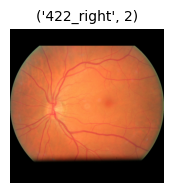

In [72]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

#fname, level = ['752_right.png'], [2] # #752_right
print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=10, size=(2,2))

In [73]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')

prediction, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0.002 0.998]
Probabilities: 		 0.998, 	 Class: 1


In [180]:
l1_norm = np.sum(np.abs(activation))
l1 = 0.00015  # .00008, .00005, 00003, .0001
l1_norm, l1*l1_norm

(4763.1953, 0.7144792968749999)

In [181]:
s = 512
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)
print(act.min(), act.max())
overlay = get_overlay_img(np_img, act)

-11.825251 264.54022


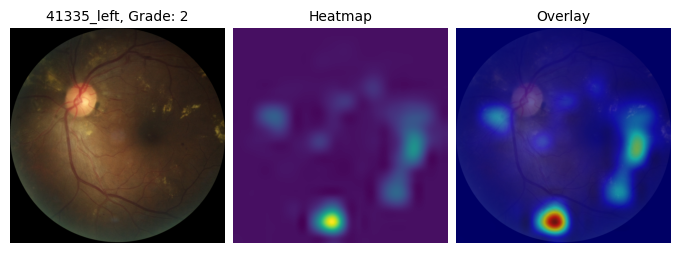

In [182]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
list_img_act_overlay = [np_img, act, overlay]
dic_title = {0: f"{fname[0][:-4]}, Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

# 33662_left.png
plot_img_heat_att(list_img_act_overlay, dic_title, size, fs=10)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Precision analysis

In [74]:
# annotations
fnames = os.listdir(anot_path)
print(dic_models.keys(), len(fnames))

dict_keys(['0', '5e5', '2e4']) 65


In [75]:
f_path = os.path.join(model_weights, 'ResNet50/fundus/files/small_bagnet_inference_annotations.csv')
data = pd.read_csv(f_path) 
#data['bin_grade'] = 1
#data = data[['filename', 'gt_level', 'bin_grade', 'res_pred', 'res_conf']] # 
print(data.shape)
data.head(3)

(65, 11)


filename  gt_level  onset1  res_pred  res_conf  cres_pred  \
0  21025_right.png         1       1         0     0.171          0   
1  41725_right.png         1       1         1     0.990          1   
2   21982_left.png         1       1         0     0.181          0   

   cres_conf  cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0      0.103              0          0.182              0          0.354  
1      0.997              1          0.983              1          0.924  
2      0.189              0          0.379              0          0.462

In [253]:
conv_model = dic_models['2e4']  

In [84]:
# predicition with FConv model  ~ conv_model 
dic_prec_acti = {}
for key, cmodel in dic_models.items():
    _, act_, _, _, pred_ = get_pred_with_heatmap(cfg, cmodel, data, img_path, cname='cres', res=False, att=False) 
    dic_prec_acti[key] = (act_, pred_)

100%|██████████| 65/65 [00:00<00:00, 72.56it/s]


In [256]:
#dic_acti = {'5e5': (activation, preds)}
#dic_acti['2e4'] = (activation, preds)

In [225]:
#out.head(3)

In [224]:
#data['cres_2e4_pred'] = out['cres_2e4_pred'] #cres_5e5
#data['cres_2e4_conf'] = out['cres_2e4_conf'] #cres_conf_5e5
#data.head(2)

In [223]:
#data.to_csv(f_path, index=False)

In [82]:
print(data.shape)
msg='Accuracy. '
tmp = {'Res': 'res_pred', 'Conv_res': 'cres_pred', 'Conv_res_5e5': 'cres_5e5_pred', 'Conv_res_2e4': 'cres_2e4_pred' }

for key, cname in tmp.items():
    msg += f'{key}: {round(accuracy_score(data.onset1, data[cname]), 4)}, \t' 
print(msg)

(65, 11)
Accuracy. Res: 0.8154, 	Conv_res: 0.8, 	Conv_res_5e5: 0.8, 	Conv_res_2e4: 0.8, 	


In [79]:
anot_fname = data.filename.tolist()

out2 = data[(data.res_pred==1) & (data.cres_pred==1) & (data.cres_5e5_pred==1) & (data.cres_2e4_pred==1)]
pred2 = data.cres_pred.tolist()

print(len(data), len(out2)) 

65 49


In [83]:
dic_prec_acti.keys()

dict_keys(['0', '5e5', '2e4'])

In [85]:
# overall precision with soft overlapping patch
dic_overall_prec = {}
for key, (act, pred) in dic_prec_acti.items():
    overall_prec, score = get_precision(act, anot_path, pred, thresh=1)
    dic_overall_prec[key] = (overall_prec, score)

65it [00:03, 17.12it/s]
65it [00:01, 47.23it/s] 
65it [00:01, 61.17it/s] 


In [87]:
print(score, round(overall_prec[overall_prec.predict==1]['labels'].mean(), 3))
overall_prec.head(3)

0.525 0.537


filename      coords  scores         min_max  labels  predict
0  41725_right.png  (200, 192)  58.053  (-3.14, 58.05)       1        1
1  41725_right.png   (64, 344)   6.228  (-3.14, 58.05)       0        1
2  41725_right.png  (128, 408)   3.072  (-3.14, 58.05)       0        1

In [89]:
# overall precision with non overlapping patches
dic_non_overall_prec = {}
for key, (act, pred) in dic_prec_acti.items():
    overall_prec2, score2, patch_scores = get_non_overlap_precision(act, pred, img_path, anot_path, thresh=1)
    dic_non_overall_prec[key] = (overall_prec2, score2, patch_scores )

100%|██████████| 65/65 [00:00<00:00, 466.53it/s]


In [90]:
print(score2, round(overall_prec2[overall_prec2.predict==1]['labels'].mean(), 3))
overall_prec2.head(3)

0.251 0.252


filename      coords     scores  labels  predict
0  41725_right.png  (198, 200)  58.740002       0        1
1  41725_right.png  (198, 167)  53.558998       1        1
2  41725_right.png  (231, 200)  51.459999       0        1

In [91]:
# topk precision
dic_topk_precs = {}
for key, (act, pred) in dic_prec_acti.items():
    topk_precs, topk_conv_scores, topk_conv_scores_tp = get_topk_precision(act, pred, anot_path, thresh=1, k=30)
    dic_topk_precs[key] = (topk_precs, topk_conv_scores, topk_conv_scores_tp)

100%|██████████| 29/29 [00:22<00:00,  1.26it/s]


In [92]:
print(f'All: {topk_conv_scores} \n\nTP : {topk_conv_scores_tp}')
topk_tmp = topk_precs[2]
topk_tmp.head(3)

All: [0.569, 0.585, 0.556, 0.55, 0.544, 0.548, 0.55, 0.547, 0.531, 0.526, 0.527, 0.523, 0.521, 0.524, 0.527, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525] 

TP : [0.615, 0.629, 0.586, 0.574, 0.565, 0.567, 0.568, 0.563, 0.545, 0.54, 0.54, 0.535, 0.533, 0.536, 0.539, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537]


filename      coords  scores         min_max  labels  predict
0  41725_right.png  (200, 192)  58.053  (-3.14, 58.05)       1        1
1  41725_right.png   (64, 344)   6.228  (-3.14, 58.05)       0        1
2   21982_left.png  (184, 104)   1.145   (-3.72, 1.14)       1        0

In [93]:
# non overlap topk precision
dic_non_overlap_topk_precs = {}
for key, (act, pred) in dic_prec_acti.items():
    topk_prec2, topk_score2, topk_scores_tp2  = get_topk_non_overlap_precision(act, pred, img_path, anot_path, thresh=1, k=30)
    dic_non_overlap_topk_precs[key] = (topk_prec2, topk_score2, topk_scores_tp2)

100%|██████████| 29/29 [00:02<00:00, 10.99it/s]


In [94]:
print(f'All: {topk_score2} \n\nTP : {topk_scores_tp2}')
topk_tmp = topk_prec2[2]
topk_tmp.head(3)

All: [0.407, 0.424, 0.397, 0.365, 0.371, 0.352, 0.337, 0.33, 0.328, 0.329, 0.322, 0.317, 0.308, 0.302, 0.294, 0.284, 0.281, 0.278, 0.275, 0.271, 0.27, 0.268, 0.267, 0.264, 0.266, 0.269, 0.268, 0.266, 0.264] 

TP : [0.423, 0.452, 0.423, 0.385, 0.392, 0.372, 0.354, 0.344, 0.342, 0.342, 0.332, 0.327, 0.317, 0.31, 0.3, 0.29, 0.286, 0.282, 0.279, 0.275, 0.274, 0.271, 0.27, 0.267, 0.269, 0.272, 0.271, 0.269, 0.266]


filename      coords     scores  labels  predict
0  41725_right.png  (198, 200)  58.740002       0        1
1  41725_right.png  (198, 167)  53.558998       1        1
2   21982_left.png   (165, 85)   1.157000       1        0

### Posthoc precision analysis

In [240]:
df = pd.read_csv(os.path.join(model_weights, 'csv_files/bag_res.csv'))

ffnames = list(dic_prec_acti['0'][0].keys())
len(ffnames)

65

In [229]:
#target_layer = model.layer4[1].conv2 # Adjust based on the model architecture
target_layer = model.layer4[-1]
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model),
      'GradCam': LayerGradCam(model, target_layer)} # 'Smooth_GradCam': smooth_grad_cam

In [100]:
# get attributions from each method
attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path)

  0%|          | 0/65 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 65/65 [00:24<00:00,  2.71it/s]


In [101]:
score_lists, score_tp_lists, df_outs = {}, {}, {}
xai_name = list(xai.keys()) # list of saliency methods

#score_lists['conv_resnet'] = topk_conv_scores
#score_tp_lists['conv_resnet'] = topk_conv_scores_tp

for name in xai_name:
    df_out, scores, scores_tp = get_topk_precision(attrib_dic, preds, anot_path, thresh=0.003, k=30, posthoc=name)
    df_outs[name] = df_out
    score_lists[name] = scores
    score_tp_lists[name] = scores_tp

100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


In [102]:
attrib_dic['GradCam']['41725_right.png'].max()

0.8072103

In [108]:
#cres_df_precision = {'0': dic_topk_precs['0'][0], '5e5': dic_topk_precs['5e5'][0], '2e4': dic_topk_precs['2e4'][0]}
#cres_topk_precision = {'0': dic_topk_precs['0'][1], '5e5': dic_topk_precs['5e5'][1], '2e4': dic_topk_precs['2e4'][1]}
#cres_topk_tp_precision = {'0': dic_topk_precs['0'][2], '5e5': dic_topk_precs['5e5'][2], '2e4': dic_topk_precs['2e4'][2]}

In [115]:
#all_df_precision = cres_df_precision | df_outs
#all_topk_precision = cres_topk_precision | score_lists
#all_topk_tp_precision = cres_topk_tp_precision | score_tp_lists

In [241]:
'''
to_save = {'all_df_precision': all_df_precision,           
           'all_topk_precision': all_topk_precision,
           'all_topk_tp_precision': all_topk_tp_precision}

with open(f'{model_weights}ResNet50/fundus/files/all_topk_precisions.pkl', 'wb') as file:  
    pickle.dump(to_save, file)

'''
# Reading the pickle file
with open(f'{model_weights}ResNet50/fundus/files/all_topk_precisions.pkl', 'rb') as file:  
    save_tk_precis = pickle.load(file)

all_df_precision = save_tk_precis['all_df_precision']
all_topk_precision = save_tk_precis['all_topk_precision']
all_topk_tp_precision = save_tk_precis['all_topk_tp_precision']
##'''

### Plot precision

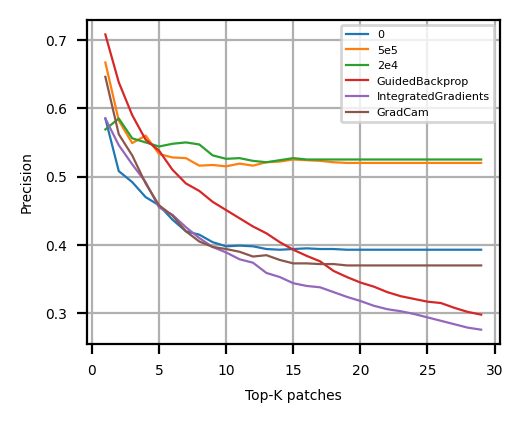

In [243]:
#sorted_score_lists = dict(sorted(score_lists.items()))
plot_precision(all_topk_precision, bb=30, fs=7, lfs=4, size=(2.5,2)) #score_tp_lists, score_lists
#plt.savefig(f'./tmp/precision.{format}', format=format) 

## Sensitivity / Faithfulness

In [252]:
f_path = os.path.join(model_weights, 'ResNet50/fundus/files/test_fundus.csv')

df_test = pd.read_csv(f_path)
print(df_test.shape)
df_test.head(3)

(6956, 10)


filename  onset1  res_pred  res_conf  cres_pred  cres_conf  \
0  13_left.png       0         0     0.099          0      0.032   
1  40_left.png       1         1     0.994          1      0.998   
2  46_left.png       0         0     0.161          0      0.016   

   cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0              0          0.159              0          0.106  
1              1          0.977              1          0.914  
2              0          0.149              0          0.357

In [123]:
# predicition with FConv model  ~ conv_model 
dic_full_test_inference = {}
for key, cmodel in dic_models.items():
    out_, d_act_, h_act_, all_act_, pred_ = get_pred_with_heatmap(cfg, cmodel, df_test, img_path, cname='cres_' + key, res=False, att=False)
    dic_full_test_inference[key] = (out_, d_act_, h_act_, all_act_, pred_)

100%|██████████| 6956/6956 [01:36<00:00, 72.29it/s]


In [259]:
# h_act and d_act ~ 60 x 60, all_act ~ 16x16
all_d_h_act = { '0': (dic_full_test_inference['0'][2], dic_full_test_inference['0'][1], dic_full_test_inference['0'][3]),
                '5e5': (dic_full_test_inference['5e5'][2], dic_full_test_inference['5e5'][1], dic_full_test_inference['5e5'][3]),
               '2e4': (dic_full_test_inference['2e4'][2], dic_full_test_inference['2e4'][1], dic_full_test_inference['2e4'][3])}

In [313]:
#df_test['cres_5e5_pred'] = dic_full_test_inference['5e5'][0]['cres_5e5_pred']
#df_test['cres_5e5_conf'] = dic_full_test_inference['5e5'][0]['cres_5e5_conf']

#df_test['cres_2e4_pred'] = dic_full_test_inference['2e4'][0]['cres_2e4_pred']
#df_test['cres_2e4_conf'] = dic_full_test_inference['2e4'][0]['cres_2e4_conf']

#df_test.to_csv(f_path, index=False)

In [260]:
msg='Accuracy. '
tmp = {'Res': 'res_pred', 'Conv_res': 'cres_pred', 'Conv_res_5e5': 'cres_5e5_pred', 'Conv_res_2e4': 'cres_2e4_pred' }

for key, cname in tmp.items():
    msg += f'{key}: {round(accuracy_score(df_test.onset1, df_test[cname]), 4)}, \t' 
print(msg)

Accuracy. Res: 0.8985, 	Conv_res: 0.8988, 	Conv_res_5e5: 0.8952, 	Conv_res_2e4: 0.9027, 	


In [127]:
df_test.onset1.value_counts()

onset1
0    5118
1    1838
Name: count, dtype: int64

In [128]:
# good predictions
good_pred = df_test[(df_test.res_pred==1) & (df_test.cres_pred==1) & (df_test.onset1==1) & (df_test.cres_5e5_pred==1) & (df_test.cres_2e4_pred==1)]
print(good_pred.shape)

(1389, 10)


In [129]:
#good_pred_conf = good_pred[(good_pred.res_conf>0.6) & (good_pred.res_conf<0.95) & (good_pred.cres_conf<0.9)]
#sort_df = good_pred_conf.sort_values(by=['res_conf', 'cres_conf'], ascending=False).reset_index(drop=True)
#final_df = sort_df[:50]

#print(good_pred_conf.shape)
#final_df.head(3)

In [130]:
#n = 100
#final_df = good_pred.sample(n, random_state=0).reset_index(drop=True)
final_df = good_pred.reset_index(drop=True)
final_fnames = final_df.filename.tolist()
final_df.head(3)

filename  onset1  res_pred  res_conf  cres_pred  cres_conf  \
0   40_left.png       1         1     0.994          1      0.998   
1  286_left.png       1         1     1.000          1      1.000   
2  396_left.png       1         1     0.996          1      0.994   

   cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0              1          0.977              1          0.914  
1              1          0.995              1          0.972  
2              1          0.909              1          0.878

In [131]:
#out, activation, _, _, _ = get_pred_with_heatmap(cfg, conv_model, df_test, img_path, cname='cres', res=False, att=False) 

#out.to_csv(f'{model_weights}csv_files/resnet/test_fundus.csv', index=False) 

In [132]:
len(final_fnames)

1389

In [133]:
dic_non_overlap_patch_scores = {}

for key, att in all_d_h_act.items():
    acts = {fname: att[1][fname] for fname in final_fnames}
    non_overlap_patch_scores = get_non_overlap_patches_scores(acts, img_path, bar=True)
    dic_non_overlap_patch_scores[key] = (non_overlap_patch_scores, acts)

100%|██████████| 1389/1389 [00:16<00:00, 82.44it/s]


In [134]:
#tmp_act = {key: activation[key] for key in final_fnames}
#tmp_non_overlap_patch_scores = get_non_overlap_patches_scores(tmp_act, img_path, bar=True)
#len(tmp_act)

In [135]:
random_activations = get_random_activation(final_fnames)
no_rand_patch_scores = get_non_overlap_patches_scores(random_activations, img_path, bar=True)

100%|██████████| 1389/1389 [00:17<00:00, 78.72it/s]


In [136]:
#tmp_no_rand_patch_scores = {key: no_rand_patch_scores[key] for key in final_fnames}

In [137]:
dic_df_prec_sens = {}
for key, (_, act) in dic_non_overlap_patch_scores.items():
    df_prec_sens = get_precision_sensitivity(act, thresh=0)
    dic_df_prec_sens[key] = df_prec_sens

1389it [01:21, 17.04it/s]
1389it [04:48,  4.81it/s]
1389it [04:53,  4.74it/s]


In [138]:
#tmp_df_prec_sens = df_prec_sens[df_prec_sens.filename.isin(final_fnames)]
#len(df_prec_sens), len(tmp_df_prec_sens)

In [139]:
print(df_prec_sens.shape)
print(df_prec_sens.filename.value_counts().min(), df_prec_sens.filename.value_counts().max())
df_prec_sens.head(3)

(50272, 4)
23 53


filename      coords  scores         min_max
0  40_left.png  (312, 104)  54.747  (-3.28, 54.75)
1  40_left.png  (136, 216)  15.374  (-3.28, 54.75)
2  40_left.png  (216, 264)  13.936  (-3.28, 54.75)

In [141]:
dic_patch_scores = {}
for key, df_prec_sens_ in  dic_df_prec_sens.items():
    patch_scores = get_overlap_patches_scores(df_prec_sens_)
    dic_patch_scores[key] = patch_scores

100%|██████████| 50272/50272 [03:37<00:00, 231.23it/s]


In [38]:
#tmp_patch_scores = {key: patch_scores[key] for key in final_fnames}

In [144]:
#non_overlap_rand_patch_scores
dic_rand_deletion = {}
for key, cmodel in dic_models.items():
    dic_rand_del, rand_perf, dic_rand_imgs = get_deletion_analysis(cfg, cmodel, no_rand_patch_scores, img_path, k=30, act=True)
    dic_rand_deletion[key] = (dic_rand_del, rand_perf)

100%|██████████| 29/29 [12:13<00:00, 25.30s/it]


In [146]:
#_, tmp_rand_perf, _ = get_deletion_analysis(cfg, conv_model, tmp_no_rand_patch_scores, img_path, k=30, act=True)

In [148]:
#patch_scores
dic_overlap_deletion = {}
for key, cmodel in dic_models.items(): #* to run again -> cmodel vs conv_model
    dic_deletion, perform, dic_imgs = get_deletion_analysis(cfg, cmodel, dic_patch_scores[key], img_path, k=30, act=True)
    dic_overlap_deletion[key] = (dic_deletion, perform, dic_imgs)

100%|██████████| 29/29 [12:21<00:00, 25.56s/it]


In [149]:
#_, tmp_perform, _ = get_deletion_analysis(cfg, conv_model, tmp_patch_scores, img_path, k=30, act=True)

In [151]:
#non_overlap_patch_scores
dic_non_overlap_deletion = {}
for key, cmodel in dic_models.items():
    dic_deletion2, perform2, dic_imgs2 = get_deletion_analysis(cfg, cmodel, dic_non_overlap_patch_scores[key][0], img_path, k=30, act=True)
    dic_non_overlap_deletion[key] = (dic_deletion2, perform2, dic_imgs2)

100%|██████████| 29/29 [12:19<00:00, 25.50s/it]


In [150]:
#_, tmp_perform2, _ = get_deletion_analysis(cfg, conv_model, tmp_non_overlap_patch_scores, img_path, k=30, act=True)

In [152]:
print(len(rand_perf), rand_perf)
print(len(perform), perform)
print(len(perform2), perform2)

30 [1, 0.9978, 0.9942, 0.9942, 0.9914, 0.9914, 0.9906, 0.9885, 0.987, 0.9899, 0.9892, 0.9899, 0.9863, 0.987, 0.987, 0.9863, 0.9856, 0.9842, 0.9834, 0.982, 0.9806, 0.9806, 0.9806, 0.9806, 0.9798, 0.9762, 0.9762, 0.977, 0.9755, 0.9748]
30 [1, 0.8546, 0.7905, 0.7811, 0.7783, 0.7883, 0.7927, 0.8042, 0.8085, 0.815, 0.82, 0.8243, 0.8323, 0.838, 0.8431, 0.8474, 0.8531, 0.8531, 0.8539, 0.8539, 0.8567, 0.8575, 0.8611, 0.8632, 0.8697, 0.8704, 0.8719, 0.8726, 0.8733, 0.8704]
30 [1, 0.9028, 0.8639, 0.8387, 0.8179, 0.8049, 0.797, 0.784, 0.7725, 0.7646, 0.7545, 0.7516, 0.7365, 0.7243, 0.7185, 0.712, 0.7019, 0.6933, 0.6919, 0.6847, 0.6746, 0.6681, 0.6631, 0.6595, 0.6602, 0.6587, 0.6443, 0.6415, 0.6429, 0.6307]


In [153]:
tmp_fname = random.sample(final_fnames, 3)
print(tmp_fname)

['36145_left.png', '21188_left.png', '20694_left.png']


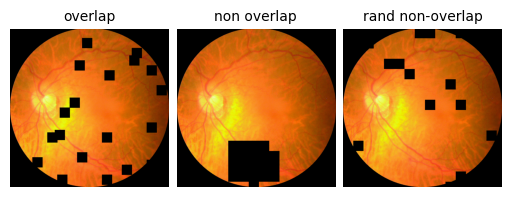

In [155]:
i, j=1, 20
list_imgs = [dic_imgs[j][tmp_fname[i]], dic_imgs2[j][tmp_fname[i]], dic_rand_imgs[j][tmp_fname[i]]]
dic_title = {0: "overlap", 1:'non overlap', 2:'rand non-overlap'}

plot_img_heat_att(list_imgs, dic_title, size=(5,10), fs=10)

In [298]:
#plot_deletion_curve(performances, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

In [160]:
'''
dic_non_overlap_sensitivity = {'cres': dic_non_overlap_deletion['0'][1], 
                               'cres_reg_5e5': dic_non_overlap_deletion['5e5'][1], #dic_non_overlap_sensitivity_['Conv_resnet_5e5'],
                              'cres_reg_2e4': dic_non_overlap_deletion['2e4'][1] #dic_non_overlap_sensitivity_['Conv_resnet_2e4']
                              }

dic_overlap_sensitivity = {'cres': dic_overlap_deletion['0'][1], 
                            'cres_reg_5e5': dic_overlap_deletion['5e5'][1], #dic_overlap_sensitivity_['Conv_resnet_5e5']
                            'cres_reg_2e4': dic_overlap_deletion['2e4'][1] #dic_overlap_sensitivity_['Conv_resnet_2e4']
                          }  

dic_random_sensitivity = {'cres': dic_rand_deletion['0'], 
                          'cres_reg_5e5': dic_rand_deletion['5e5'][1], #dic_random_sensitivity_['Conv_resnet_5e5']
                          'cres_reg_2e4': dic_rand_deletion['2e4'][1] #dic_random_sensitivity_['Conv_resnet_2e4']
                         }

dic_df_precision_sensitivity = {'cres': dic_df_prec_sens['0'], 
                          'cres_reg_5e5': dic_df_prec_sens['5e5'], #dic_df_precision_sensitivity_['Conv_resnet_5e5'], #,
                          'cres_reg_2e4': dic_df_prec_sens['2e4'] #dic_df_precision_sensitivity_ ['Conv_resnet_2e4'], #
                               }
                         
dic_patch_score = {'cres': dic_non_overlap_patch_scores['0'][0],
                    'cres_reg_5e5': dic_non_overlap_patch_scores['5e5'][0],
                   'cres_reg_2e4': dic_non_overlap_patch_scores['2e4'][0]
                  }
'''
print()

In [408]:
'''
to_save = { 'all_d_h_heatmaps': all_d_h_act,
            'lg_activation': lg_activation_dic,
            'pg_activation': pg_activation_dic,
            'patch_scores': dic_patch_scores,
            'dic_patch_score': dic_patch_score,
            'df_prec_sens': dic_df_precision_sensitivity,
            'random_sensitivity': dic_random_sensitivity,
            'overlap_sensitivity': dic_overlap_sensitivity, #*
            'non_overlap_sensitivity': dic_non_overlap_sensitivity, #*
            'non_overlap_rand_patch_scores': no_rand_patch_scores}

with open(f'{model_weights}ResNet50/fundus/files/cres_sensitivity_analysis.pkl', 'wb') as file: 
    pickle.dump(to_save, file)
'''

with open(f'{model_weights}ResNet50/fundus/files/cres_sensitivity_analysis.pkl', 'rb') as file:  
    tk_precis_all = pickle.load(file)

print()

In [296]:
dic_non_overlap_sensitivity.keys()

dict_keys(['cres', 'cres_reg_5e5', 'cres_reg_2e4'])

In [262]:
dic_patch_scores = tk_precis_all['patch_scores']
dic_random_sensitivity = tk_precis_all['random_sensitivity']
dic_df_precision_sensitivity = tk_precis_all['df_prec_sens']
dic_overlap_sensitivity = tk_precis_all['overlap_sensitivity']
dic_non_overlap_sensitivity = tk_precis_all['non_overlap_sensitivity']

Area under the deletion curve
cres: 	 0.691541379310345
cres_reg_5e5: 	 0.6884810344827587
cres_reg_2e4: 	 0.7325431034482758


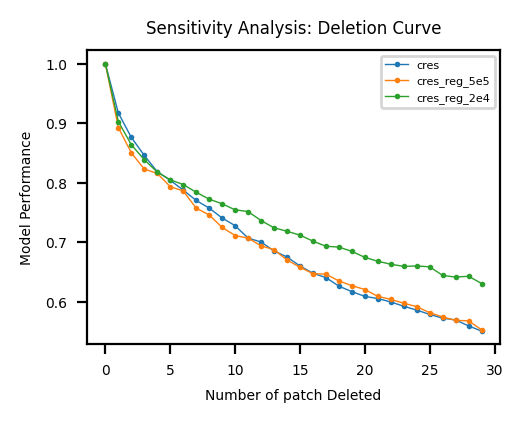

In [263]:
plot_deletion_curve(dic_non_overlap_sensitivity, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

#### Plot posthoc

In [285]:
#final_df
ffnames = df_test.filename.tolist()
print(len(ffnames))

6956


In [286]:
## Generate activation maps from saliency methods
d_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, target=1)

  0%|          | 0/6956 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 6956/6956 [47:48<00:00,  2.43it/s] 


In [287]:
h_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, target=0)

100%|██████████| 6956/6956 [53:39<00:00,  2.16it/s]


In [288]:
fname_sens = final_df.filename.tolist()
len(fname_sens)

1389

In [289]:
sens_attrib_dic = {}

for key, actt in d_attrib_dic.items():
    tmp_act = {key2: actt[key2] for key2 in fname_sens}
    sens_attrib_dic[key] = tmp_act

In [ ]:
sens_attrib_dic = {key: d_attrib_dic[key] for key in fname_sens}

In [276]:
attrib_dic.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [277]:
#to_save = {'attrib_dic': attrib_dic, 'list_attrib_sens': list_act_prec, 'all_sensitivity': all_act_prec}

#with open(f'{model_weights}ResNet50/fundus/files/attrib_cres_sensitivity_analysis.pkl', 'wb') as file: 
#    pickle.dump(to_save, file)
'''
with open(f'{model_weights}ResNet50/fundus/files/attrib_cres_sensitivity_analysis.pkl', 'rb') as file:  
    save_attrib_dic = pickle.load(file)

attrib_disease_acts = save_attrib_dic['attrib_dic']
attrib_act_sens = save_attrib_dic['list_attrib_sens']
'''
print()

In [290]:
attrib_sensitivity = {}

for name, actis in tqdm(sens_attrib_dic.items()):
    no_over_patch_scores = get_non_overlap_patches_scores(actis, img_path, bar=False)
    dic_del, perf2, dic_img = get_deletion_analysis(cfg, model, no_over_patch_scores, img_path, bar=False, k=30, act=False)
    attrib_sensitivity[name] = perf2

100%|██████████| 3/3 [39:33<00:00, 791.17s/it]


In [306]:
'''
to_save = {'all_attrib_act': (h_attrib_dic, d_attrib_dic), #
          'attrib_sens': sens_attrib_dic, # only image use for sensitivity
          'res_attrib_sensitivity': attrib_sensitivity,
          'res_cres_sensitivity': all_act_prec}

with open(f'{model_weights}ResNet50/fundus/files/all_res_attrib_and_other.pkl', 'wb') as file: 
    pickle.dump(to_save, file)
'''
print()

In [304]:
#dd = {'Conv_res': perform2}
all_act_prec = dic_non_overlap_sensitivity | attrib_sensitivity
all_act_prec.keys()

dict_keys(['cres', 'cres_reg_5e5', 'cres_reg_2e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

Area under the deletion curve. cres: 0.691541379310345
Area under the deletion curve. cres_reg_5e5: 0.6884810344827587
Area under the deletion curve. cres_reg_2e4: 0.7325431034482758
Area under the deletion curve. GuidedBackprop: 0.5740982758620689
Area under the deletion curve. IntegratedGradients: 0.6267206896551725
Area under the deletion curve. GradCam: 0.6414982758620689


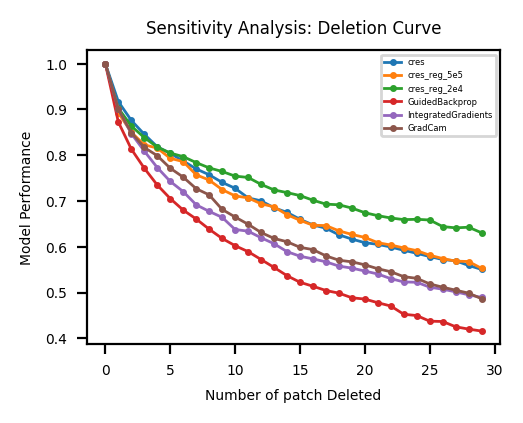

In [308]:
plot_deletion_curve_v2(all_act_prec, label='Deletion Curve', bb=30, frac=False, fs=7, ms=1.5, lfs=3, size=(2.5,2))

### Pointing game grid metric

In [ ]:
(h_attrib_dic, d_attrib_dic)

In [309]:
h_attrib_dic.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [310]:
all_d_h_act.keys() # (h_act, d_act)

dict_keys(['0', '5e5', '2e4'])

In [311]:
print(len(all_d_h_act['0'][0]), len(h_attrib_dic['GradCam']))
print(all_d_h_act['0'][0]['21025_right.png'].shape, h_attrib_dic['GradCam']['21025_right.png'].shape)

6956 6956
(60, 60) (60, 60)


In [115]:
df_final = healthy_pred.sample(2000, random_state=0).reset_index(drop=True)
final_fnames = df_final.filename.tolist()

In [316]:
#_, _, h_activation, _ = get_pred_with_heatmap(cfg, conv_model, df_final, img_path, cname='cres', res=False, att=False)

In [317]:
#healthy_attrib_dic = get_posthoc_explanation(cfg, final_fnames, xai, img_path, target=0)

In [323]:
df_test = pd.read_csv(f_path)

df_test.head(2)

filename  onset1  res_pred  res_conf  cres_pred  cres_conf  \
0  13_left.png       0         0     0.099          0      0.032   
1  40_left.png       1         1     0.994          1      0.998   

   cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0              0          0.159              0          0.106  
1              1          0.977              1          0.914

In [344]:
healthy_pred = df_test[(df_test.res_pred==0) & (df_test.cres_pred==0) & (df_test.onset1==0) & (df_test.cres_5e5_pred==0) & (df_test.cres_2e4_pred==0)]
healthy_fname = healthy_pred.filename.tolist()
healthy_pred.shape

(4526, 10)

In [329]:
# good predictions
disease_pred = df_test[(df_test.res_pred==1) & (df_test.cres_pred==1) & (df_test.onset1==1) & (df_test.cres_5e5_pred==1) & (df_test.cres_2e4_pred==1)]

disease_pred = disease_pred.reset_index(drop=True)
disease_fnames = disease_pred.filename.tolist()
disease_pred.shape

(1389, 10)

In [ ]:
all_d_h_act.keys() # (h_act, d_act, _)

In [340]:
cres_heathy_disease_acts = {}
for key, (h_act_, d_act_, _) in all_d_h_act.items():
    tmp_dic = {ll: h_act_[ll] for ll in healthy_fname}
    tmp_dic2 = {ll: d_act_[ll] for ll in disease_fnames}
    cres_heathy_disease_acts[key] = (tmp_dic, tmp_dic2)

In [354]:
attrib_healthy_disease_acts = {} #(h_attrib_dic, d_attrib_dic)
for key in d_attrib_dic.keys():
    tmp_dic = {ll: h_attrib_dic[key][ll] for ll in healthy_fname}
    tmp_dic2 = {ll: d_attrib_dic[key][ll] for ll in disease_fnames}
    attrib_healthy_disease_acts[key] = (tmp_dic, tmp_dic2)

In [356]:
cres_heathy_disease_acts.keys(), attrib_healthy_disease_acts.keys()

(dict_keys(['0', '5e5', '2e4']),
 dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam']))

In [357]:
pg_activation_dic = cres_heathy_disease_acts | attrib_healthy_disease_acts
pg_activation_dic.keys()

dict_keys(['0', '5e5', '2e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [373]:
pg_acts = {}
for name, actt in pg_activation_dic.items(): 
    heathy_act, disease_act = actt
    pg_score = get_pointing_game_sensitivity_score(disease_act, heathy_act, bar=False)
    pg_acts[name] = pg_score
    print(f'{name}\t\t\t| {pg_score}')

0			| 0.10729417490492633
5e5			| 0.20365020471625997
2e4			| 0.20510701152668656
GuidedBackprop			| 0.2492109039596152
IntegratedGradients			| 0.2501503470090196
GradCam			| 0.120017663344344


### From local to global

In [80]:
len(all_cres_acti.keys()), all_heathy_cres_acti['13_left.png'].shape, all_disease_acti_attrib['GuidedBackprop']['13_left.png'].shape

(6956, (60, 60), (60, 60))

In [374]:
all_d_h_act.keys()

dict_keys(['0', '5e5', '2e4'])

In [379]:
df_test.head(2)

filename  onset1  res_pred  res_conf  cres_pred  cres_conf  \
0  13_left.png       0         0     0.099          0      0.032   
1  40_left.png       1         1     0.994          1      0.998   

   cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0              0          0.159              0          0.106  
1              1          0.977              1          0.914

In [387]:
s=60
all_cres_acts = {}
all_fnames = df_test.filename.tolist()

for key, (_, _, act_) in all_d_h_act.items():
    tmp_h_act = {ll: cv2.resize(act_[ll][0], dsize=(s,s), interpolation=cv2.INTER_CUBIC) for ll in all_fnames}
    tmp_d_act = {ll: cv2.resize(act_[ll][1], dsize=(s,s), interpolation=cv2.INTER_CUBIC) for ll in all_fnames}
    all_cres_acts[key] = (tmp_h_act, tmp_d_act)

In [390]:
all_attrib_acts = {} 
for key in d_attrib_dic.keys():
    tmp_dic = {ll: h_attrib_dic[key][ll] for ll in all_fnames}
    tmp_dic2 = {ll: d_attrib_dic[key][ll] for ll in all_fnames}
    all_attrib_acts[key] = (tmp_dic, tmp_dic2)

In [409]:
f_path

'../Model_weights/Fully_ConvNet/ResNet50/fundus/files/test_fundus.csv'

In [391]:
df_desease = df_test[df_test.onset1==1].reset_index(drop=True)
df_healthy = df_test[df_test.onset1==0].reset_index(drop=True)

d_fnames = df_desease.filename.tolist()
h_fnames = df_healthy.filename.tolist()

print(len(df_desease), len(df_healthy))
df_test.head(3)

1838 5118


filename  onset1  res_pred  res_conf  cres_pred  cres_conf  \
0  13_left.png       0         0     0.099          0      0.032   
1  40_left.png       1         1     0.994          1      0.998   
2  46_left.png       0         0     0.161          0      0.016   

   cres_5e5_pred  cres_5e5_conf  cres_2e4_pred  cres_2e4_conf  
0              0          0.159              0          0.106  
1              1          0.977              1          0.914  
2              0          0.149              0          0.357

In [393]:
lg_activation_dic = all_cres_acts | all_attrib_acts
lg_activation_dic.keys()

dict_keys(['0', '5e5', '2e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [404]:
p_pos = get_local_to_global_positive(lg_activation_dic, d_fnames)

Proportion of positive activations
0- 			| 0.2818
5e5- 			| 0.5042
2e4- 			| 0.5041
GuidedBackprop- 			| 0.4996
IntegratedGradients- 			| 0.4991
GradCam- 			| 0.3047


In [407]:
p_neg = get_local_to_global_negative(lg_activation_dic, h_fnames)

Proportion of negative activations
0 			| 0.1371
5e5 			| 0.2727
2e4 			| 0.2815
GuidedBackprop 			| 0.2308
IntegratedGradients 			| 0.232
GradCam 			| 0.0923


### Sparse models selection

In [160]:
#to_save = {'overal': preci, 'topk': topk_preci, 'params': sort_test_reg, 'regs_precs': regs_precs}

#with open(f'{model_weights}ResNet50/fundus/files/sparse_model_selection.pkl', 'wb') as file: 
#    pickle.dump(to_save, file)

with open(f'{model_weights}ResNet50/fundus/files/sparse_model_selection.pkl', 'rb') as file:  
    save_model_select = pickle.load(file)

preci = save_model_select['overal']
topk_preci = save_model_select['topk']
sort_test_reg = save_model_select['params']
regs_precs = save_model_select['regs_precs']

In [157]:
test_reg = [(0.898, 0.925, 0, '0'), (0.903, 0.924, 1e-05, '1e5'), (0.900, 0.928, 2e-05, '2e5'),
            (0.900,0.926,  3e-05, '3e5'), (0.895, 0.922, 4e-05, '4e5'), (0.895, 0.923, 5e-05, '5e5'), 
            (0.904, 0.925, 6e-05, '6e5'), (0.899, 0.924, 7e-05, '7e5'), (0.900, 0.924, 8e-05, '8e5'), 
            (0.894, 0.922, 9e-05, '9e5'), (0.903, 0.923, 1e-4, '1e4'), (0.899, 0.925, 1.2e-4, '12e4'), 
            (0.897, 0.923, 1.5e-4, '15e4'), (0.902, 0.917, 2e-4, '2e4'), (0.900, 0.916, 2.5e-4,'25e4'), 
            (0.893, 0.910, 3e-4, '3e4'),  (0.895, 0.902, 3.5e-4, '35e4'), (0.888, 0.914, 4e-4, '4e4'), 
            (0.849, 0.907, 5e-4, '5e4'), (0.832, 0.887, 6e-4, '6e4'), (0.844, 0.866, 7e-4, '7e4'), 
            (0.834, 0.887, 8e-4, '8e4'), (0.844, 0.869, 9e-4, '9e4')]

regs = [ll[2] for ll in test_reg]
sort_test_reg = sorted(test_reg, key=lambda x: x[2]) # , reverse=True

In [ ]:
model_surfix = [ll[3] for ll in test_reg]
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/fundus/reg'

preci, topk_preci = run_eval(cfg, data, model_surfix, prefix, model_path, img_path, anot_path, thresh=1, k=30)

In [155]:
#regs_precs = list(zip(regs, preci))

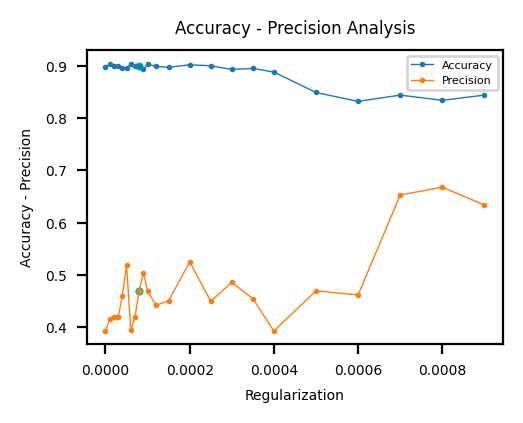

In [163]:
r_precs = [ll[1] for ll in regs_precs]
plot_overall_accuracy(sort_test_reg, r_precs, i=0, j=2, k=8, fs=7, lfs=4, size=(2.5,2))

In [168]:
#plot overall precision
#plot_overall_precision(regs_precs, i=21, fs=7, size=(2.5,2))

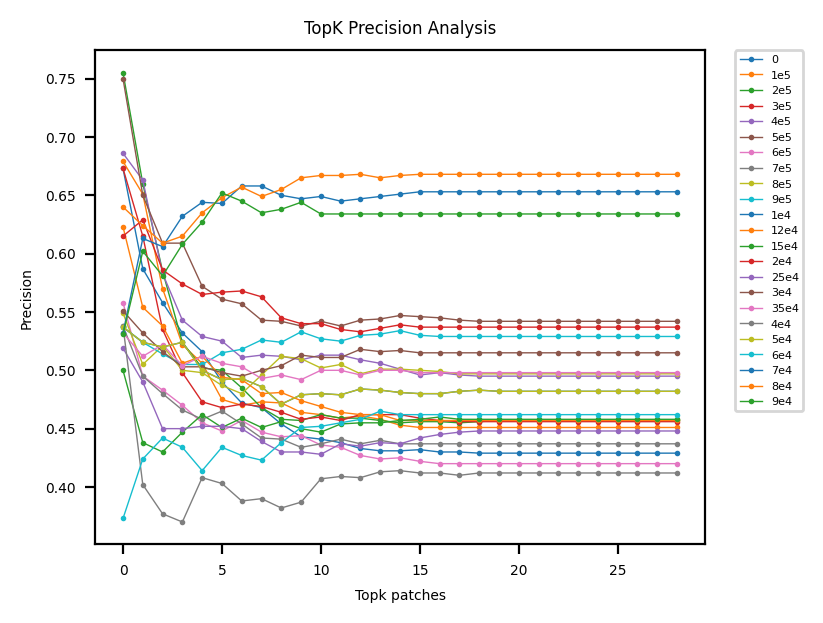

In [174]:
# topk precision
plot_topk_reg(topk_preci, 'TopK Precision Analysis', i=1, fs=7, lfs=4, size=(4,3))

# Retinal OCT 

In [4]:
cnames = ['patient_id', 'filenames', 'level']
model_weights = '../Model_weights/Fully_ConvNet/'
anot_path = model_weights + 'oct_masks'
path = "/gpfs01/berens/data/data/kermani_oct/CellData/OCT_preprocessed_resized_3_channels_496/"
img_path = "/gpfs01/berens/data/data/kermani_oct/CellData/OCT_preprocessed_resized_3_channels_496/"

cfg.data.input_size = 496 
cfg.data.mean = [0.19075624644756317, 0.19075624644756317, 0.19075624644756317]
cfg.data.std  = [0.22165445983409882, 0.22165445983409882, 0.22165445983409882]

train = pd.read_csv(path + "train_normal_drusen.csv")
val   = pd.read_csv(path + "val_normal_drusen.csv")
test  = pd.read_csv(path + "test_normal_drusen.csv")
test  = test[cnames]
test.rename(columns={'filenames': 'filename'}, inplace=True)

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test))
test.head(3)

27430 7532 498


patient_id                          filename  level
0     8196333  test/DRUSEN/DRUSEN-8196333-1.png      1
1     2465519  test/DRUSEN/DRUSEN-2465519-1.png      1
2     8258303  test/DRUSEN/DRUSEN-8258303-1.png      1

## Models

In [28]:
#model = models.resnet50()
#model.fc = torch.nn.Linear(2048, 2)
#model.load_state_dict(torch.load(model_weight, weights_only=False), strict=True)
#torch.save(obj=model, f='best_validation_weights_acc_m.pt')

In [52]:
folder = 'ResNet50/'
model_weight = model_weights + folder + 'oct/oct_resnet_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [22]:
model_weight = model_weights + folder + 'oct/oct_conv_resnet_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

In [17]:
surfix = ['0', '3e4']
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/oct/reg'

dic_models = {}
for ll in surfix:
    cmodel = torch.load(os.path.join(model_path, ll + prefix), weights_only=False)
    cmodel = cmodel.to('cuda')
    cmodel.eval()
    dic_models[ll] = cmodel
    
dic_models.keys()

dict_keys(['0', '3e4'])

## Inference

test/DRUSEN/DRUSEN-6409462-3.png 1


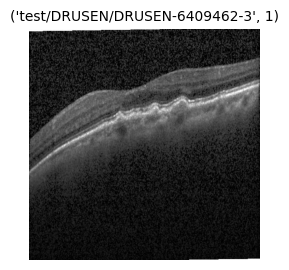

In [19]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=10)

In [20]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')
ts_img.shape, np_img.shape

(torch.Size([1, 3, 496, 496]), (496, 496, 3))

In [23]:
pred, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0. 1.]
Probabilities: 		 1.0, 	 Class: 1


In [24]:
l1_norm = np.sum(np.abs(activation))
l1 = 0.0005
l1_norm, l1*l1_norm

(4294.83, 2.1474150390625)

In [25]:
s = cfg.data.input_size
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)

print(act.min(), act.max(), act.shape)
overlay = get_overlay_img(np_img, act)

-15.026172 217.71628 (496, 496)


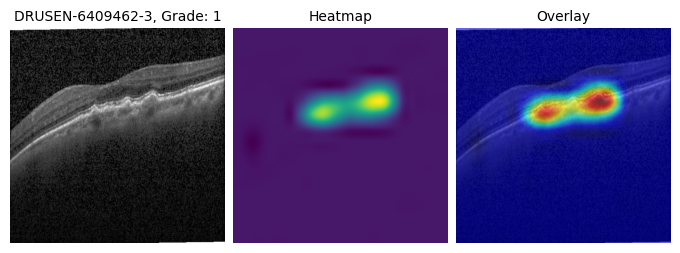

In [26]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
ll = [np_img, act, overlay]
lll = {0: f"{fname[0].split('/')[-1][:-4]}, Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

plot_img_heat_att(ll, lll, size, fs=10)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Annotations

In [27]:
f_path = path + 'drusen_samples_v2_prototypes/'
fnames = os.listdir(f_path)

df_anot = pd.read_csv(model_weights + 'csv_files/oct/annotation_v2.csv')
df_training_anot = pd.read_csv(model_weights + 'csv_files/oct/training_img_annotation.csv')
df_anot = pd.concat([df_anot, df_training_anot])

print(df_anot.shape, df_anot.filename.nunique())
df_anot.head(3)

(252, 5) 45


filename label    x    y color
0  DRUSEN-9807719-1    DS  169  218   red
1  DRUSEN-9807719-1    DS  198  225   red
2  DRUSEN-9807719-1    DS  274  226   red

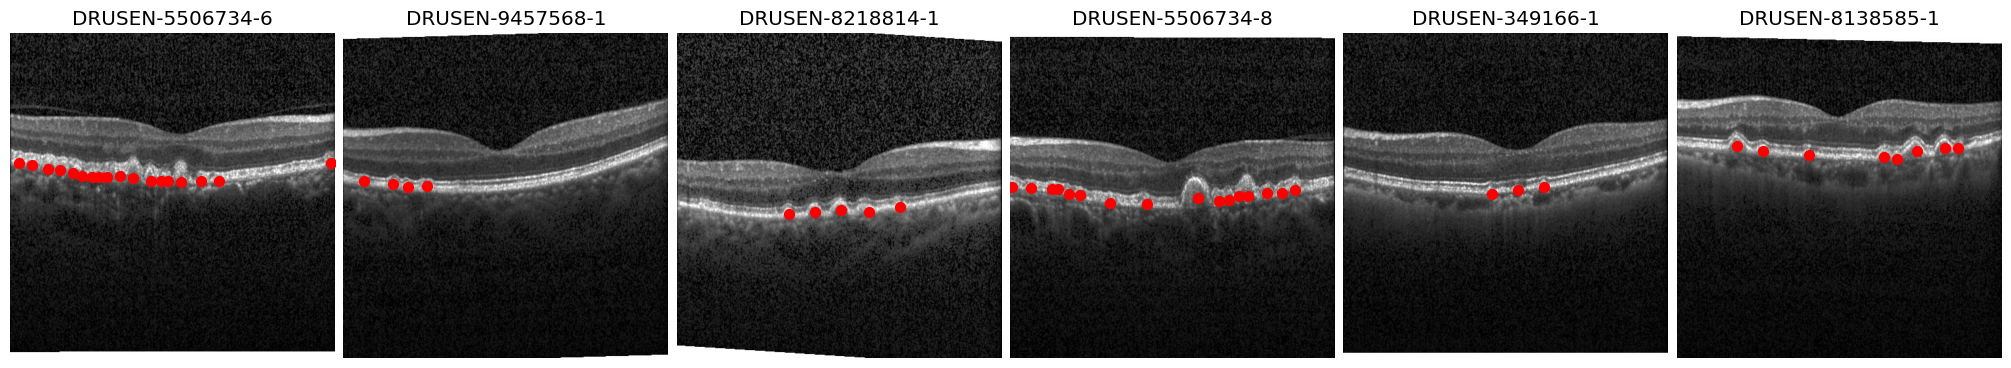

In [30]:
df_ = df_anot.sample(6).reset_index(drop=True)
plot_annotations(df_anot, f_path, s=50, nrow=1, ncol=6, size=(20,5))

In [553]:
#img = cv2.imread(f_path + 'prototype-img-original9.png')
#cv2.imwrite('prototype-img-original9.png', img)
#img.shape

## All inference

In [196]:
to_save = {'dic_prec_acti': dic_prec_acti,
          'd_attrib_dic': d_attrib_dic,
          'h_attrib_dic': h_attrib_dic}

with open(f'{model_weights}ResNet50/oct/files/toooopppppppppppp.pkl', 'wb') as file: 
    pickle.dump(to_save, file)

In [36]:
dic_models.keys()

dict_keys(['0', '3e4'])

In [8]:
f_path = os.path.join(model_weights, 'ResNet50/oct/files/test.csv')
data = pd.read_csv(f_path) 
print(data.shape)
data.head(3)

(498, 6)


filename  level  res_conf  res_pred  cres_conf  \
0  test/DRUSEN/DRUSEN-8196333-1.png      1     0.999         1        1.0   
1  test/DRUSEN/DRUSEN-2465519-1.png      1     1.000         1        1.0   
2  test/DRUSEN/DRUSEN-8258303-1.png      1     1.000         1        1.0   

   cres_pred  
0          1  
1          1  
2          1

In [ ]:
torch.nn.functional.softmax

In [54]:
# resnet model
fnames = data.filename.tolist()
out = model_eval(cfg, model, fnames, img_path, act=False)

data['res_conf'] = np.round(out['predict_proba'][:,1], 3)
data['res_pred'] = out['predict_class']

100%|██████████| 498/498 [00:27<00:00, 18.04it/s]


In [108]:
## cresnet
# predicition with FConv model  ~ conv_model 
dic_prec_acti = {}
for key, cmodel in dic_models.items():
    out, d_act, h_act, all_act, pred = get_pred_with_heatmap(cfg, cmodel, data, img_path, s=58, cname='cres', res=False, att=False) 
    dic_prec_acti[key] = (out, d_act, h_act, all_act, pred)

100%|██████████| 498/498 [00:10<00:00, 47.89it/s]


In [74]:
data['cres_conf'] = dic_prec_acti['0'][0]['cres_conf']
data['cres_pred'] = dic_prec_acti['0'][0]['cres_pred']

In [82]:
dic_prec_acti['0'][1]['test/DRUSEN/DRUSEN-8196333-1.png'].shape

(60, 60)

In [90]:
df_sensitivity = data[(data.res_pred==1) & (data.cres_pred==1)]
df_sensitivity.shape

(246, 6)

In [109]:
print(data.shape)
msg='Accuracy. '
tmp = {'Res': 'res_pred', 'Conv_res': 'cres_pred'} #'Conv_res_5e5': 'cres_5e5_pred', 'Conv_res_2e4': 'cres_2e4_pred'

for key, cname in tmp.items():
    msg += f'{key}: {round(accuracy_score(data.level, data[cname]), 4)}, \t' 
print(msg)

(498, 6)
Accuracy. Res: 0.994, 	Conv_res: 0.994, 	


In [76]:
#data.to_csv(f_path, index=False)

In [164]:
# attrib inference
target_layer = model.layer4[-1]
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model), 
      'GradCam': LayerGradCam(model, target_layer)} # 'Smooth_GradCam': smooth_grad_cam

In [165]:
ffnames = data.filename.tolist()

In [166]:
d_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, s=58, target=1)

  0%|          | 0/498 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 498/498 [08:47<00:00,  1.06s/it]


In [167]:
h_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, s=58, target=0)

100%|██████████| 498/498 [08:46<00:00,  1.06s/it]


## Precision analysis

In [185]:
# read anot df
save_dir = model_weights + 'oct_masks'
#masks = get_oct_masks(df_anot, f_path, save_dir)

In [9]:
fname_ = os.listdir(anot_path)
fnames = ['test/DRUSEN/' + ll for ll in fname_]

df_precision_anot = test[test.filename.isin(fnames)]
pred = df_precision_anot.level.tolist()

print(len(fnames))
df_precision_anot.head(2)

41


patient_id                          filename  level
6       349166   test/DRUSEN/DRUSEN-349166-1.png      1
12     5989598  test/DRUSEN/DRUSEN-5989598-1.png      1

In [113]:
df_precision_anot.level.unique()

array([1])

In [134]:
cres_anot_prec, cres_anot_prec2 = {}, {}

for key, (_, d_act, _, _, _) in dic_prec_acti.items():
    tmp_dic = {ll.split('/')[2]: d_act[ll] for ll in fnames}
    tmp_dic2 = {ll: d_act[ll] for ll in fnames}
    
    cres_anot_prec[key] = tmp_dic
    cres_anot_prec2[key] = tmp_dic2

In [137]:
len(cres_anot_prec2['0'])

40

In [122]:
# overall precision with soft overlapping patch
cres_overall_prec = {}
for key, act in cres_anot_prec.items():
    overall_prec, score = get_precision(act, anot_path, pred, thresh=1, act_size=58)
    cres_overall_prec[key] = (overall_prec, score)

40it [00:01, 24.01it/s]
40it [00:00, 138.67it/s]


In [116]:
cres_overall_prec.keys()

dict_keys(['0', '3e4'])

In [123]:
print(score, round(overall_prec[overall_prec.predict==1]['labels'].mean(), 3), cres_overall_prec['0'][1])
overall_prec.head(3)

0.804 0.804 0.462


filename      coords  scores         min_max  labels  predict
0  DRUSEN-3618354-1.png  (192, 192)  35.425  (-1.84, 35.42)       1        1
1  DRUSEN-3618354-1.png  (176, 192)  35.304  (-1.84, 35.42)       1        1
2   DRUSEN-695291-1.png  (192, 192)  35.425  (-1.84, 35.42)       1        1

In [138]:
# overall precision with non overlapping patches
cres_non_overall_prec = {}
for key, act in cres_anot_prec2.items():
    overall_prec2, score2, patch_scores = get_non_overlap_precision(act, pred, img_path, anot_path, thresh=1, size=(496, 496))
    cres_non_overall_prec[key] = (overall_prec2, score2, patch_scores )

100%|██████████| 40/40 [00:00<00:00, 402.22it/s]


In [139]:
# topk precision
cres_topk_precs = {}
for key, act in cres_anot_prec2.items():
    topk_precs, topk_conv_scores, topk_conv_scores_tp = get_topk_precision(act, pred, anot_path, thresh=1, k=30, act_size=58)
    cres_topk_precs[key] = (topk_precs, topk_conv_scores, topk_conv_scores_tp)

100%|██████████| 29/29 [00:07<00:00,  3.83it/s]


In [140]:
print(f'All: {topk_conv_scores} \n\nTP : {topk_conv_scores_tp}')
topk_tmp = topk_precs[2]
topk_tmp.head(3)

All: [0.8, 0.8, 0.8, 0.8, 0.802, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804] 

TP : [0.8, 0.8, 0.8, 0.8, 0.802, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804, 0.804]


filename      coords  scores         min_max  \
0  test/DRUSEN/DRUSEN-3618354-1.png  (192, 192)  35.425  (-1.84, 35.42)   
1  test/DRUSEN/DRUSEN-3618354-1.png  (176, 192)  35.304  (-1.84, 35.42)   
2   test/DRUSEN/DRUSEN-695291-1.png  (192, 192)  35.425  (-1.84, 35.42)   

   labels  predict  
0       1        1  
1       1        1  
2       1        1

In [142]:
# non overlap topk precision
dic_non_overlap_topk_precs = {}
for key, act in cres_anot_prec2.items():
    topk_prec2, topk_score2, topk_scores_tp2  = get_topk_non_overlap_precision(act, pred, img_path, anot_path, thresh=1, k=30, size=(496, 496))
    dic_non_overlap_topk_precs[key] = (topk_prec2, topk_score2, topk_scores_tp2)

100%|██████████| 29/29 [00:01<00:00, 16.89it/s]


In [159]:
print(cres_presisions_['0'])

[0.8, 0.724, 0.613, 0.52, 0.493, 0.475, 0.468, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462, 0.462]


In [168]:
dd_attrib_dic = {}
for key, act in d_attrib_dic.items():
    tmp_act = {ll: act[ll] for ll in fnames}
    dd_attrib_dic[key] = tmp_act

dd_attrib_dic.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [169]:
score_lists, score_tp_lists, df_outs = {}, {}, {}
xai_name = list(xai.keys()) # list of saliency methods

for name in xai_name: # 
    print(name)
    df_out, scores, scores_tp = get_topk_precision(dd_attrib_dic, pred, anot_path, thresh=0.003, k=30, act_size=58, posthoc=name)
    df_out_, scores_, scores_tp_ = get_topk_non_overlap_precision(dd_attrib_dic, pred, img_path, anot_path, thresh=0.003, k=30, posthoc=name, size=(496,496))
        
    df_outs[name] = (df_out, df_out_)
    score_lists[name] = (scores, scores_)
    score_tp_lists[name] = (scores_tp, scores_tp_)

GuidedBackprop


100%|██████████| 29/29 [00:01<00:00, 16.65it/s]


IntegratedGradients


100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


GradCam


100%|██████████| 29/29 [00:01<00:00, 16.06it/s]


In [176]:
print(score_lists['GradCam'][0])

[0.775, 0.675, 0.533, 0.45, 0.382, 0.325, 0.282, 0.249, 0.224, 0.204, 0.189, 0.177, 0.168, 0.161, 0.156, 0.152, 0.15, 0.148, 0.145, 0.143, 0.142, 0.142, 0.141, 0.141, 0.141, 0.141, 0.141, 0.141, 0.141]


In [182]:
cres_presisions = {key: val[1] for key, val in dic_non_overlap_topk_precs.items()}
cres_presisions_ = {key: val[1] for key, val in cres_topk_precs.items()}

res_attrib_precisions = {key: val[1] for key, val in score_lists.items()}
res_attrib_precisions_ = {key: val[0] for key, val in score_lists.items()}

cres_presisions.keys(), res_attrib_precisions.keys()

(dict_keys(['0', '3e4']),
 dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam']))

In [193]:
all_topk_tp_precision = cres_presisions_ | res_attrib_precisions_
all_topk_tp_precision.keys()

dict_keys(['0', '3e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [194]:
print(cres_presisions['3e4'])

[0.625, 0.5, 0.45, 0.419, 0.425, 0.367, 0.354, 0.331, 0.308, 0.285, 0.282, 0.269, 0.254, 0.241, 0.232, 0.223, 0.214, 0.211, 0.201, 0.191, 0.187, 0.18, 0.173, 0.168, 0.164, 0.159, 0.155, 0.153, 0.15]


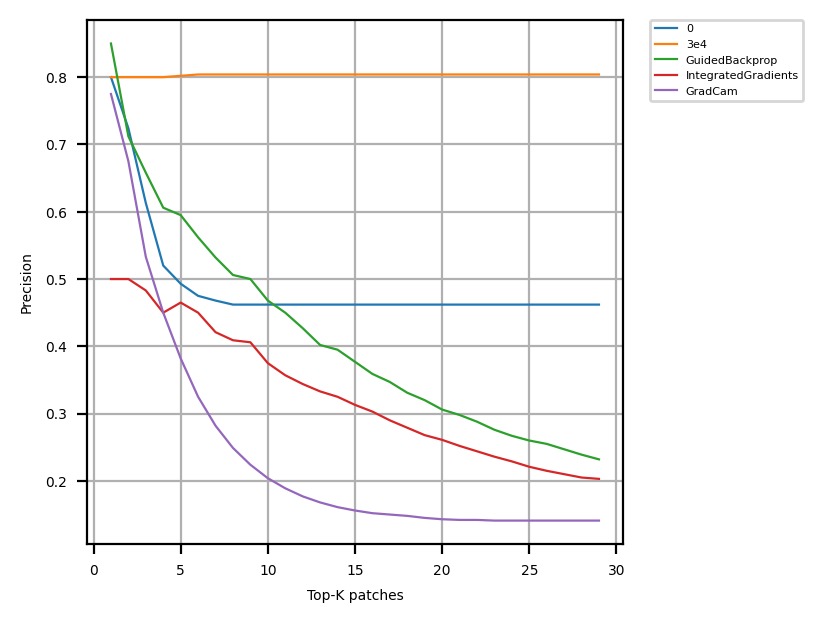

In [195]:
## plot precision
plot_precision(all_topk_tp_precision, bb=30, fs=7, lfs=4, out=True, size=(4,3)) #score_tp_lists, score_lists
#plt.savefig(f'./tmp/precision.{format}', format=format) 

/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


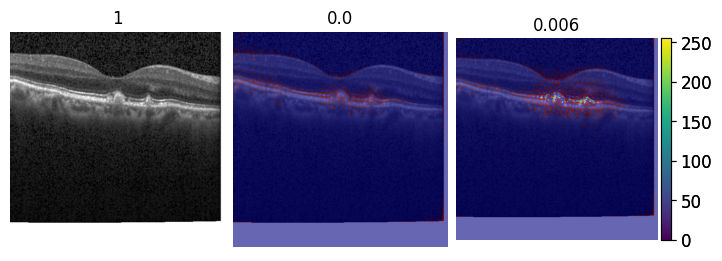

In [606]:
explainer = GuidedBackprop(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer, v2=False, s=496, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, y_prob[0], (6.69,2.5), nrow=1, fs=12)

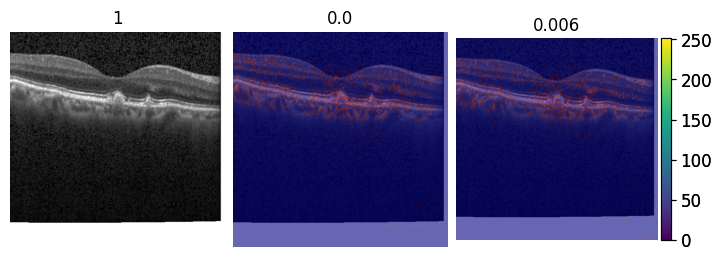

In [605]:
explainer2 = IntegratedGradients(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer2, v2=False, s=496, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, y_prob[0], (6.69,2.5), nrow=1, fs=12)

## Sensitivity / Faithfulness

In [208]:
f_path = os.path.join(model_weights, 'ResNet50/oct/files/test.csv')
df_test = pd.read_csv(f_path)
size = (496, 496)

print(df_test.shape)
df_test.head(3)

(498, 6)


filename  level  res_conf  res_pred  cres_conf  \
0  test/DRUSEN/DRUSEN-8196333-1.png      1     0.999         1        1.0   
1  test/DRUSEN/DRUSEN-2465519-1.png      1     1.000         1        1.0   
2  test/DRUSEN/DRUSEN-8258303-1.png      1     1.000         1        1.0   

   cres_pred  
0          1  
1          1  
2          1

In [ ]:
# predicition with FConv model  ~ conv_model 
dic_prec_acti

In [204]:
# good predictions
df_sensitivity = df_test[(df_test.level==1) & (df_test.res_pred==1) & (df_test.cres_pred==1)]
fname_sensitity = df_sensitivity.filename.tolist()

print(df_sensitivity.shape)

(245, 6)


In [209]:
cres_non_overlap_patch_scores = {}

for key, (_, att, _, _, _) in dic_prec_acti.items():
    acts = {fname: att[fname] for fname in fname_sensitity}
    non_overlap_patch_scores = get_non_overlap_patches_scores(acts, img_path, bar=True, size=size)
    cres_non_overlap_patch_scores[key] = (non_overlap_patch_scores, acts)

100%|██████████| 245/245 [00:02<00:00, 108.26it/s]


In [210]:
random_activations = get_random_activation(fname_sensitity)
no_rand_patch_scores = get_non_overlap_patches_scores(random_activations, img_path, bar=True, size=size)

100%|██████████| 245/245 [00:02<00:00, 105.93it/s]


In [211]:
cres_df_prec_sens = {}

for key, (_, act) in cres_non_overlap_patch_scores.items():
    df_prec_sens = get_precision_sensitivity(act, thresh=0, act_size=58)
    cres_df_prec_sens[key] = df_prec_sens

245it [00:11, 20.44it/s]
245it [00:10, 24.47it/s]


In [213]:
print(df_prec_sens.shape)
print(df_prec_sens.filename.value_counts().min(), df_prec_sens.filename.value_counts().max())
df_prec_sens.head(3)

(9508, 4)
16 71


filename      coords  scores         min_max
0  test/DRUSEN/DRUSEN-8196333-1.png  (216, 232)  67.759  (-2.37, 67.76)
1  test/DRUSEN/DRUSEN-8196333-1.png  (232, 128)   0.216  (-2.37, 67.76)
2  test/DRUSEN/DRUSEN-8196333-1.png  (240, 344)   0.192  (-2.37, 67.76)

In [214]:
cres_patch_scores = {}
for key, df_prec_sens_ in  cres_df_prec_sens.items():
    patch_scores = get_overlap_patches_scores(df_prec_sens_)
    cres_patch_scores[key] = patch_scores

100%|██████████| 9508/9508 [00:19<00:00, 480.59it/s]


In [ ]:
#non_overlap_rand_patch_scores
cres_rand_deletion = {}

for key, cmodel in dic_models.items():
    dic_rand_del, rand_perf, dic_rand_imgs = get_deletion_analysis(cfg, cmodel, no_rand_patch_scores, img_path, k=30, act=True)
    cres_rand_deletion[key] = (dic_rand_del, rand_perf)

 55%|█████▌    | 16/29 [01:07<00:55,  4.29s/it]

In [218]:
#patch_scores
cres_overlap_deletion = {}
for key, cmodel in dic_models.items(): #* to run again -> cmodel vs conv_model
    dic_deletion, perform, dic_imgs = get_deletion_analysis(cfg, cmodel, cres_patch_scores[key], img_path, k=30, act=True)
    cres_overlap_deletion[key] = (dic_deletion, perform, dic_imgs)

100%|██████████| 29/29 [02:02<00:00,  4.23s/it]


In [220]:
#non_overlap_patch_scores
cres_non_overlap_deletion = {}
for key, cmodel in dic_models.items():
    dic_deletion2, perform2, dic_imgs2 = get_deletion_analysis(cfg, cmodel, cres_non_overlap_patch_scores[key][0], img_path, k=30, act=True)
    cres_non_overlap_deletion[key] = (dic_deletion2, perform2, dic_imgs2)

100%|██████████| 29/29 [02:03<00:00,  4.26s/it]


In [221]:
print(len(rand_perf), rand_perf)
print(len(perform), perform)
print(len(perform2), perform2)

30 [1, 0.9918, 0.9918, 0.9918, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9878, 0.9837, 0.9837, 0.9837, 0.9837, 0.9837, 0.9837, 0.9796, 0.9796, 0.9796, 0.9796, 0.9755, 0.9673, 0.9673, 0.9592]
30 [1, 0.9224, 0.9143, 0.898, 0.8939, 0.8939, 0.8939, 0.8898, 0.8898, 0.8898, 0.8898, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8939, 0.8857, 0.8857, 0.8816, 0.8816, 0.8816, 0.8816]
30 [1, 0.9429, 0.8531, 0.7918, 0.7306, 0.6449, 0.6122, 0.5388, 0.502, 0.4694, 0.4245, 0.3633, 0.3429, 0.2776, 0.2612, 0.2408, 0.2245, 0.2041, 0.1755, 0.1796, 0.1551, 0.1429, 0.1184, 0.0776, 0.0531, 0.0571, 0.0449, 0.0408, 0.0245, 0.0163]


In [224]:
tmp_fname = random.sample(fname_sensitity, 3)
print(tmp_fname)

['test/DRUSEN/DRUSEN-5506734-1.png', 'test/DRUSEN/DRUSEN-9890012-1.png', 'test/DRUSEN/DRUSEN-2658240-1.png']


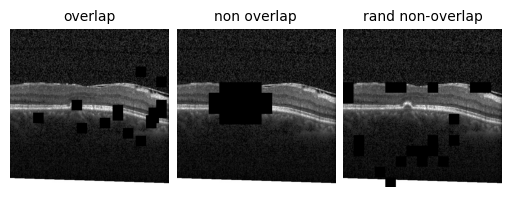

In [226]:
i, j=1, 20
list_imgs = [dic_imgs[j][tmp_fname[i]], dic_imgs2[j][tmp_fname[i]], dic_rand_imgs[j][tmp_fname[i]]]
dic_title = {0: "overlap", 1:'non overlap', 2:'rand non-overlap'}

plot_img_heat_att(list_imgs, dic_title, size=(5,10), fs=10)

In [229]:
cres_sensitivity = {key: val[1] for key, val in cres_non_overlap_deletion.items()}

Area under the deletion curve
0: 	 0.5794482758620688
3e4: 	 0.34490517241379304


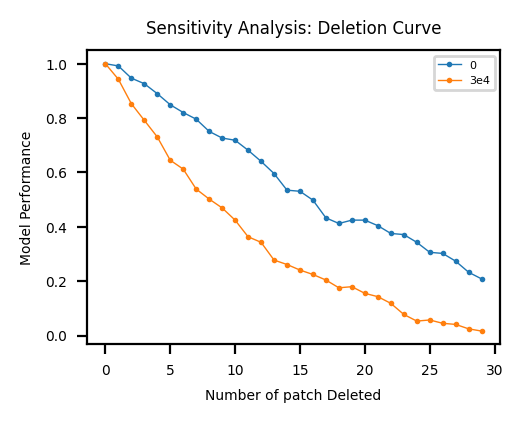

In [230]:
plot_deletion_curve(cres_sensitivity, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

In [239]:
## Res attrib
sens_attrib_dic = {}

for key, act in d_attrib_dic.items():
    tmp_dic = {ll: act[ll] for ll in fname_sensitity}
    sens_attrib_dic[key] = tmp_dic

In [240]:
attrib_sensitivity = {}

for name, actis in tqdm(sens_attrib_dic.items()):
    no_over_patch_scores = get_non_overlap_patches_scores(actis, img_path, bar=False)
    dic_del, perf2, dic_img = get_deletion_analysis(cfg, model, no_over_patch_scores, img_path, bar=False, k=30, act=False)
    attrib_sensitivity[name] = perf2

100%|██████████| 3/3 [06:26<00:00, 128.68s/it]


In [243]:
all_act_prec = cres_sensitivity | attrib_sensitivity
all_act_prec.keys()

dict_keys(['0', '3e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

Area under the deletion curve. 0: 0.5794482758620688
Area under the deletion curve. 3e4: 0.34490517241379304
Area under the deletion curve. GuidedBackprop: 0.6841689655172414
Area under the deletion curve. IntegratedGradients: 0.7015482758620691
Area under the deletion curve. GradCam: 0.7325810344827587


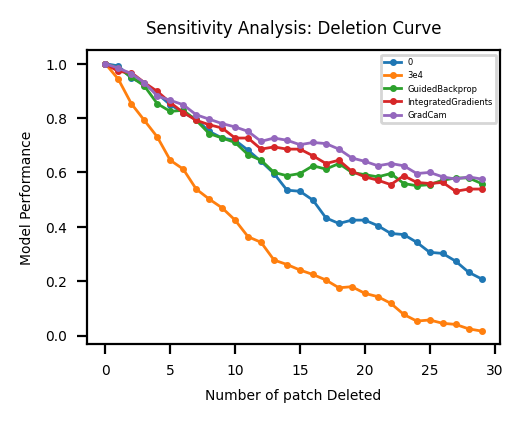

In [244]:
plot_deletion_curve_v2(all_act_prec, label='Deletion Curve', bb=30, frac=False, fs=7, ms=1.5, lfs=3, size=(2.5,2))

### Pointing game grid metric

In [249]:
#df_sensitivity, fname_sensitity
df_healthy = data[(data.res_pred==0) & (data.level==0) & (data.cres_pred==0)]
fname_healty = df_healthy.filename.tolist()

In [251]:
cres_heathy_disease_acts = {}
for key, (_, d_act_, h_act_, _, _) in dic_prec_acti.items():
    tmp_dic = {ll: h_act_[ll] for ll in fname_healty}
    tmp_dic2 = {ll: d_act_[ll] for ll in fname_sensitity}
    cres_heathy_disease_acts[key] = (tmp_dic, tmp_dic2)

In [252]:
attrib_healthy_disease_acts = {} #(h_attrib_dic, d_attrib_dic)
for key in d_attrib_dic.keys():
    tmp_dic = {ll: h_attrib_dic[key][ll] for ll in fname_healty}
    tmp_dic2 = {ll: d_attrib_dic[key][ll] for ll in fname_sensitity}
    attrib_healthy_disease_acts[key] = (tmp_dic, tmp_dic2)

In [254]:
pg_activation_dic = cres_heathy_disease_acts | attrib_healthy_disease_acts
pg_activation_dic.keys()

dict_keys(['0', '3e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [255]:
pg_acts = {}
for name, actt in pg_activation_dic.items(): 
    heathy_act, disease_act = actt
    pg_score = get_pointing_game_sensitivity_score(disease_act, heathy_act, bar=False)
    pg_acts[name] = pg_score
    print(f'{name}\t\t\t| {pg_score}')

0			| 0.1020202769628401
3e4			| 0.10071709041421763
GuidedBackprop			| 0.2559926414732129
IntegratedGradients			| 0.2507067995545021
GradCam			| 0.24396591854184804


### From local to global

In [256]:
all_fnames = df_test.filename.tolist()

In [259]:
s=60
all_cres_acts = {}
all_fnames = df_test.filename.tolist()

for key, (_, d_act_, h_act_, _, _) in dic_prec_acti.items():
    tmp_h_act = {ll: h_act_[ll] for ll in all_fnames}
    tmp_d_act = {ll: d_act_[ll] for ll in all_fnames}
    all_cres_acts[key] = (tmp_h_act, tmp_d_act)

In [257]:
all_attrib_acts = {} 
for key in d_attrib_dic.keys():
    tmp_dic = {ll: h_attrib_dic[key][ll] for ll in all_fnames}
    tmp_dic2 = {ll: d_attrib_dic[key][ll] for ll in all_fnames}
    all_attrib_acts[key] = (tmp_dic, tmp_dic2)

In [262]:
df_desease = df_test[df_test.level==1].reset_index(drop=True)
df_healthy = df_test[df_test.level==0].reset_index(drop=True)

d_fnames = df_desease.filename.tolist()
h_fnames = df_healthy.filename.tolist()

print(len(df_desease), len(df_healthy))

248 250


In [263]:
lg_activation_dic = all_cres_acts | all_attrib_acts
lg_activation_dic.keys()

dict_keys(['0', '3e4', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [264]:
p_pos = get_local_to_global_positive(lg_activation_dic, d_fnames)

Proportion of positive activations
0 			| 0.2945
3e4 			| 0.27
GuidedBackprop 			| 0.5273
IntegratedGradients 			| 0.5007
GradCam 			| 0.6059


In [265]:
p_neg = get_local_to_global_negative(lg_activation_dic, h_fnames)

Proportion of negative activations
0 			| 0.1341
3e4 			| 0.1937
GuidedBackprop 			| 0.489
IntegratedGradients 			| 0.5011
GradCam 			| 0.372


## Sparse model selection

In [38]:
to_save = {'overal': preci, 'topk': topk_preci, 'params': sort_test_reg, 'sort_regs_precs': regs_precis, 'regs_precs': regs_precis}

with open(f'{model_weights}ResNet50/oct/files/sparse_model_selection.pkl', 'wb') as file: 
    pickle.dump(to_save, file)

#with open(f'{model_weights}ResNet50/rsna/files/sparse_model_selection.pkl', 'rb') as file:  
#    save_model_selection = pickle.load(file)

In [6]:
test_reg = [(0.9939, 0.9999, 0, '0'), (0.9959, 0.99995, 2e-4, '2e4'), (0.9959, 0.9999, 34-4, '3e4'), (0.9919,  0.99995, 4e-4, '4e4'), (0.9959, 0.99994, 5e-4,'5e4'), 
      (0.9979, 0.99997, 6e-4, '6e4'), (0.9979, 0.99998, 7e-4, '7e4'), (0.9919, 0.99994, 8e-4, '8e4'), (0.9939, 0.99987, 9e-4, '9e4'), (0.9959, 0.99994, 1e-3, '1e3'), 
            (0.9959, 0.9999, 1.1e-3, '11e3'), (0.9979, 0.99985, 1.2e-3, '12e3'), (0.9959, 0.99998, 1.3e-3, '13e3'), (0.9899, 0.9999, 1.4e-3, '14e3'), (0.9959, 0.99995, 1.5e-3, '15e3')]

sort_test_reg = sorted(test_reg, key=lambda x: x[2])
regs = [ll[2] for ll in sort_test_reg]

In [ ]:
model_surfix = [ll[3] for ll in sort_test_reg]
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/oct/reg'

preci, topk_preci = run_eval(cfg, df_precision_anot, model_surfix, prefix, model_path, img_path, anot_path, thresh=1, s=58, k=30)

In [35]:
regs_precis = list(zip(regs, preci))

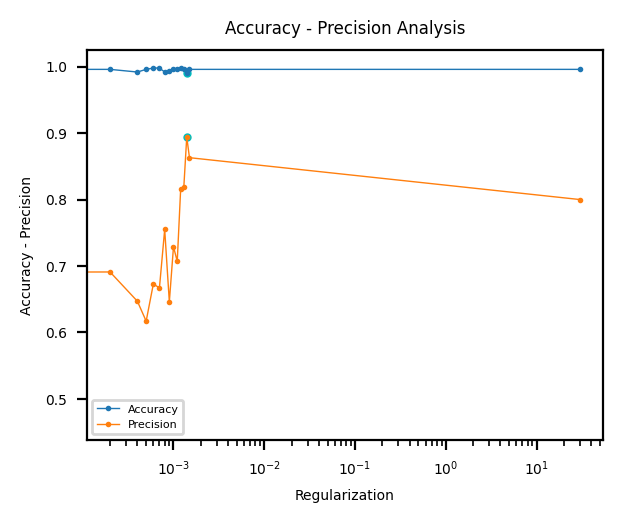

In [36]:
r_precs = [ll[1] for ll in regs_precis]
plot_overall_accuracy(sort_test_reg, r_precs, log_ax=True, i=0, j=2, k=12, fs=7, lfs=4, size=(3,2.5))

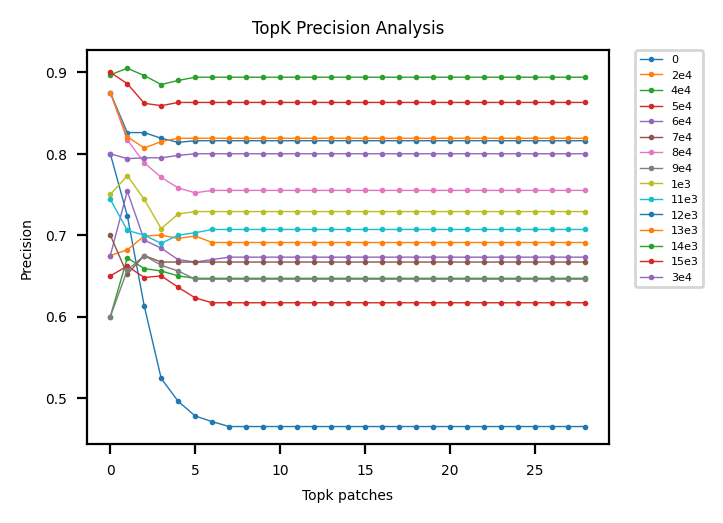

In [37]:
plot_topk_reg(topk_preci, 'TopK Precision Analysis', i=1, fs=7, lfs=4, size=(3.5,2.5))

## RSA Pneumonia 

In [5]:
scale = 512/1024
model_weights = '../Model_weights/Fully_ConvNet/'
anot_path = model_weights + 'rsna_masks_v2'
path = "/gpfs01/berens/data/data/ChestXray_images/RSNA_challenge/"
img_path = "/gpfs01/berens/data/data/ChestXray_images/RSNA_challenge/png_images/"

cfg.data.input_size = 512 
cfg.data.mean = [0.488974928855896, 0.488974928855896, 0.488974928855896]
cfg.data.std  = [0.2458493560552597, 0.2458493560552597, 0.2458493560552597]

train = pd.read_csv(path + 'train.csv')
val   = pd.read_csv(path + 'val.csv')
test  = pd.read_csv(path + "test.csv")

test['filename'] = test.patientId.apply(lambda x: x + '.png')
test.rename(columns={'bin_target':'level'}, inplace=True)

test = test[['filename', 'x', 'y', 'width', 'height', 'level']]

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test), len(disease))
test.head(3)

11369 1264 2230 902


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  262.0  400.0  154.0   168.0   

   level  
0      1  
1      1  
2      1

In [6]:
anot_path

'../Model_weights/Fully_ConvNet/rsna_masks_v2'

In [7]:
all_df = pd.read_csv(path + 'stage_2_train_labels.csv')

all_df['x'] = all_df['x'] * scale 
all_df['y'] = all_df['y'] * scale
all_df['width'] = all_df['width'] * scale
all_df['height'] = all_df['height'] * scale

## Models

In [8]:
folder = 'ResNet50/rsna/'
model_weight = model_weights + folder + 'resnet_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [96]:
model_weight = model_weights + folder + 'conv_resnet_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

In [27]:
surfix = ['0', '8e4', '9e4', '1e3'] #'0', 
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/rsna/reg'

dic_models = {}
for ll in surfix:
    cmodel = torch.load(os.path.join(model_path, ll + prefix), weights_only=False)
    cmodel = cmodel.to('cuda')
    cmodel.eval()
    dic_models[ll] = cmodel
    
dic_models.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

## Inference

97b7fb68-359d-46f4-b20f-5cb82bb8dd81.png 1


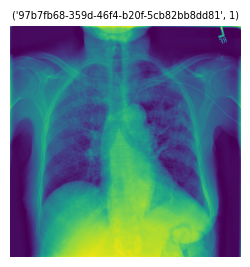

In [19]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=7)

In [167]:
ts_img, np_img = load_image(cfg, img_path, fname[0], xchest=True)
ts_img = ts_img.to('cuda')
ts_img.shape, np_img.shape

(torch.Size([1, 3, 512, 512]), (512, 512, 3))

In [168]:
pred, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0.007 0.993]
Probabilities: 		 0.9928, 	 Class: 1


In [169]:
#l1_norm = np.sum(np.abs(activation))
#l1 = 0.00005  # .00008, .00005, .0001
#l1_norm, l1*l1_norm

In [170]:
s = cfg.data.input_size
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)

print(act.min(), act.max())
overlay = get_overlay_img(np_img, act)

-41.649597 143.29643


In [171]:
np_img.shape, act.shape

((512, 512, 3), (512, 512))

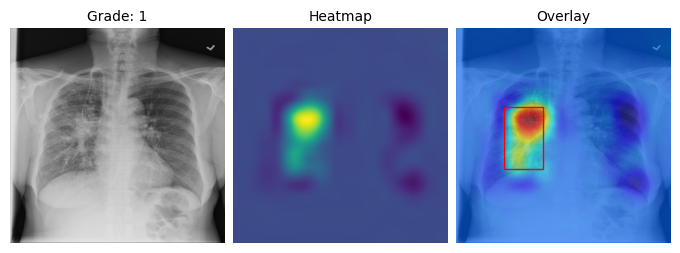

In [172]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
img_act_overlay = [np_img, act, overlay]
title = {0: f"Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

plot_img_heat_att_v2(img_act_overlay, title, size, fs=10, df=all_df, file=fname)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Test inference and visualization

In [8]:
fnames = test.filename.tolist()
len(fnames)

2230

In [9]:
#out = model_eval(cfg, conv_model, fnames, img_path, act=True)

In [10]:
#df = test.copy()
#df['cres_conf'] = np.round(out['predict_proba'][:, 1], decimals=3)
#df['cres_pred'] = out['predict_class']
#df.to_csv(f'{model_weights}csv_files/rsna/inference.csv', index=False) 

In [45]:
out = pd.read_csv(f'{model_weights}csv_files/rsna/inference.csv')
out['x'] = out['x'] * scale 
out['y'] = out['y'] * scale
out['width'] = out['width'] * scale
out['height'] = out['height'] * scale

out_healthy = out[(out.level==0) & (out.res_pred==0) & (out.cres_pred==0)].reset_index(drop=True)
out_disease = out[(out.level==1) & (out.res_pred==1) & (out.cres_pred==1)].reset_index(drop=True)
print(len(out_healthy), len(out_disease))
out.head(3)

1255 810


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  318.5  138.0   94.0   141.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  319.0  159.5  129.0   229.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  131.0  200.0   77.0    84.0   

   level  res_conf  res_pred  cres_conf  cres_pred  
0      1       1.0         1      0.997          1  
1      1       1.0         1      0.999          1  
2      1       1.0         1      0.992          1

In [20]:
round(accuracy_score(out.level, out.res_pred), 3), round(accuracy_score(out.level, out.cres_pred), 3)

(0.953, 0.942)

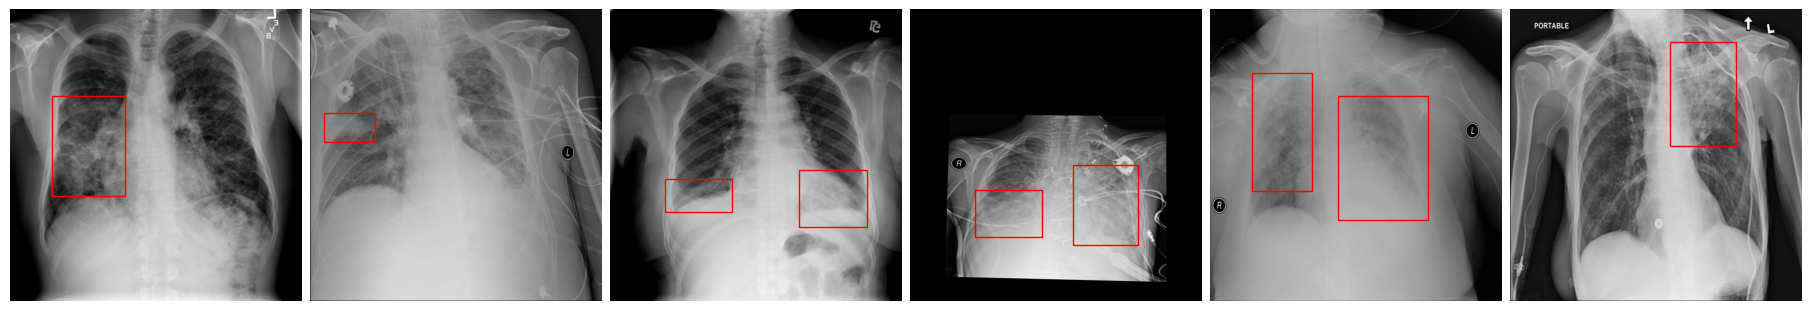

In [21]:
sample = disease.sample(6).reset_index(drop=True)
plot_xchest_with_bb(sample, all_df, img_path, size = (18,4))

## Precision analysis

In [ ]:
dic_prec_acti

In [36]:
'''
to_save = {'dic_prec_acti': dic_prec_acti, 
          'dic_disease_prec_acti': dic_disease_prec_acti,
          'dic_overall_prec': dic_overall_prec,
          'dic_non_overall_prec': dic_non_overall_prec,
          'dic_topk_precs': dic_topk_precs,
          'dic_non_overlap_topk_precs': dic_non_overlap_topk_precs,
          'd_attrib_dic': d_attrib_dic,
           'h_attrib_dic': h_attrib_dic,
           'df_outs':df_outs,
           'score_lists': score_lists,
           'score_tp_lists': score_tp_lists
          }

with open(f'{model_weights}ResNet50/rsna/files/tmpppppppppppppppppppppppppppppp.pkl', 'wb') as file: 
    pickle.dump(to_save, file)
'''
print()

In [10]:
with open(f'{model_weights}ResNet50/rsna/files/tmpppppppppppppppppppppppppppppp.pkl', 'rb') as file:  
    save_tmp = pickle.load(file)

dic_prec_acti = save_tmp['dic_prec_acti']
dic_disease_prec_acti = save_tmp['dic_disease_prec_acti']
dic_overall_prec = save_tmp['dic_overall_prec']
dic_non_overall_prec = save_tmp['dic_non_overall_prec']
dic_topk_precs = save_tmp['dic_topk_precs']
dic_non_overlap_topk_precs = save_tmp['dic_non_overlap_topk_precs']
d_attrib_dic = save_tmp['d_attrib_dic']
h_attrib_dic = save_tmp['h_attrib_dic']
df_outs = save_tmp['df_outs']
score_lists = save_tmp['score_lists']
score_tp_lists = save_tmp['score_tp_lists'] 

In [109]:
print(disease.shape, test.shape)
df_disease = disease.copy()

(902, 6) (2230, 6)


In [12]:
f_path = os.path.join(model_weights, 'ResNet50/rsna/files', 'inference.csv')
df_test = pd.read_csv(f_path)
print(df_test.shape)
df_test.head(3)

(2230, 16)


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  262.0  400.0  154.0   168.0   

   level  res_conf  res_pred  cres_conf  cres_pred  cres_8e4_pred  \
0      1       1.0         1      0.997          1              1   
1      1       1.0         1      0.999          1              1   
2      1       1.0         1      0.992          1              1   

   cres_8e4_conf  cres_9e4_pred  cres_9e4_conf  cres_1e3_pred  cres_1e3_conf  
0          0.789              1          0.767              1          0.738  
1          0.827              1          0.790              1          0.821  
2          0.687              1          0.703              1          0.672

In [105]:
# disease out_disease
#save_xchest_masks(disease, all_df, img_path, anot_path, s=512)

In [100]:
# good prediction from all models
#df_precision = out_disease.sample(100, random_state=0)

In [113]:
dic_models.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [32]:
dic_prec_acti = {}  # rerun
for key, cmodel in dic_models.items():
    out_, d_act_, h_act_, all_act_, pred_ = get_pred_with_heatmap(cfg, cmodel, test, img_path, cname=key, s=60, res=False, att=False) 
    dic_prec_acti[key] = (out_, d_act_, h_act_, all_act_, pred_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [01:36<00:00, 23.17it/s]


In [129]:
#df_test['cres_8e4_pred'] = dic_prec_acti['8e4'][0]['8e4_pred'] 
#df_test['cres_8e4_conf'] = dic_prec_acti['8e4'][0]['8e4_conf']

#df_test['cres_9e4_pred'] = dic_prec_acti['9e4'][0]['9e4_pred'] 
#df_test['cres_9e4_conf'] = dic_prec_acti['9e4'][0]['9e4_conf']

In [127]:
#df_test.to_csv(f_path, index=False)

In [148]:
print(df_test.shape)
df_test.head(2)

(2230, 16)


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   

   level  res_conf  res_pred  cres_conf  cres_pred  cres_8e4_pred  \
0      1       1.0         1      0.997          1              1   
1      1       1.0         1      0.999          1              1   

   cres_8e4_conf  cres_9e4_pred  cres_9e4_conf  cres_1e3_pred  cres_1e3_conf  
0          0.789              1          0.767              1          0.738  
1          0.827              1          0.790              1          0.821

In [150]:
msg='Accuracy. '
tmp = {'Res': 'res_pred', 'Conv_res': 'cres_pred', 'Conv_res_8e4': 'cres_8e4_pred', 'Conv_res_9e4': 'cres_9e4_pred', 'Conv_res_1e3': 'cres_1e3_pred' }

for key, cname in tmp.items():
    msg += f'{key}: {round(accuracy_score(df_test.level, df_test[cname]), 4)}, \t' 
print(msg)

Accuracy. Res: 0.9534, 	Conv_res: 0.9417, 	Conv_res_8e4: 0.9457, 	Conv_res_9e4: 0.9386, 	Conv_res_1e3: 0.9413, 	


In [155]:
anot_fname = df_disease.filename.tolist()

In [13]:
df_disease_pred = df_test[(df_test.res_pred==1) & (df_test.cres_pred==1) & (df_test.cres_8e4_pred==1) & (df_test.cres_9e4_pred==1) & (df_test.cres_1e3_pred==1)]
df_disease_pred.shape

(797, 16)

In [213]:
dic_disease_prec_acti = {} # only disease activation
for key, cmodel in dic_models.items():
    _, d_act_, _, _, pred_ = get_pred_with_heatmap(cfg, cmodel, df_disease, img_path, cname=key, s=60, res=False, att=False) 
    dic_disease_prec_acti[key] = (d_act_, pred_)

100%|██████████| 902/902 [00:36<00:00, 24.75it/s]


In [145]:
# overall precision with soft overlapping patch
dic_overall_prec = {}
for key, (act, pred) in dic_disease_prec_acti.items():
    overall_prec, score = get_precision(act, anot_path, pred, thresh=1, xchest=True)
    dic_overall_prec[key] = (overall_prec, score)

902it [01:56,  7.75it/s]
902it [00:07, 128.11it/s]
902it [00:05, 153.08it/s]
902it [00:04, 188.90it/s]


In [146]:
# overall precision with non overlapping patches
dic_non_overall_prec = {}
for key, (act, pred) in dic_disease_prec_acti.items():
    overall_prec2, score2, patch_scores = get_non_overlap_precision(act, pred, img_path, anot_path, thresh=1, xchest=True)
    dic_non_overall_prec[key] = (overall_prec2, score2, patch_scores )

100%|██████████| 902/902 [00:01<00:00, 524.08it/s]


In [ ]:
print(score2, round(overall_prec2[overall_prec2.predict==1]['labels'].mean(), 3))
overall_prec2.head(3)

In [151]:
# topk precision
dic_topk_precs = {}
for key, (act, pred) in dic_disease_prec_acti.items():
    topk_precs, topk_conv_scores, topk_conv_scores_tp = get_topk_precision(act, pred, anot_path, thresh=1, k=30, xchest=True)
    dic_topk_precs[key] = (topk_precs, topk_conv_scores, topk_conv_scores_tp)

100%|██████████| 29/29 [02:03<00:00,  4.27s/it]


In [152]:
print(f'All: {topk_conv_scores} \n\nTP : {topk_conv_scores_tp}')
topk_tmp = topk_precs[2]
topk_tmp.head(3)

All: [0.87, 0.831, 0.807, 0.797, 0.791, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788, 0.788] 

TP : [0.871, 0.831, 0.806, 0.797, 0.79, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787, 0.787]


filename      coords  scores  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  (200, 192)  20.138   
1  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  (368, 192)  15.370   
2  d7545025-6654-4cc3-83d1-99a34476c72a.png  (392, 312)  22.835   

          min_max  labels  predict  
0  (-1.67, 20.14)       1        1  
1  (-1.67, 20.14)       1        1  
2  (-1.55, 22.83)       1        1

In [153]:
# non overlap topk precision
dic_non_overlap_topk_precs = {}
for key, (act, pred) in dic_disease_prec_acti.items():
    topk_prec2, topk_score2, topk_scores_tp2  = get_topk_non_overlap_precision(act, pred, img_path, anot_path, thresh=1, k=30, xchest=True)
    dic_non_overlap_topk_precs[key] = (topk_prec2, topk_score2, topk_scores_tp2)

100%|██████████| 29/29 [00:35<00:00,  1.21s/it]


In [198]:
dic_non_overlap_topk_precs.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [200]:
cres_presisions = {key: val[1] for key, val in dic_non_overlap_topk_precs.items()}
cres_presisions.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [154]:
print(f'All: {topk_score2} \n\nTP : {topk_scores_tp2}')
topk_tmp = topk_prec2[2]
topk_tmp.head(3)

All: [0.864, 0.857, 0.854, 0.848, 0.843, 0.837, 0.833, 0.827, 0.822, 0.815, 0.809, 0.804, 0.798, 0.792, 0.787, 0.782, 0.778, 0.772, 0.769, 0.764, 0.759, 0.754, 0.75, 0.746, 0.743, 0.739, 0.737, 0.734, 0.731] 

TP : [0.866, 0.86, 0.856, 0.851, 0.845, 0.84, 0.835, 0.83, 0.825, 0.818, 0.812, 0.806, 0.8, 0.794, 0.789, 0.784, 0.78, 0.774, 0.77, 0.766, 0.76, 0.755, 0.751, 0.747, 0.744, 0.74, 0.738, 0.734, 0.731]


filename      coords     scores  labels  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  (198, 203)  20.351999       1   
1  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  (198, 170)  19.473000       1   
2  d7545025-6654-4cc3-83d1-99a34476c72a.png  (396, 330)  23.459000       1   

   predict  
0        1  
1        1  
2        1

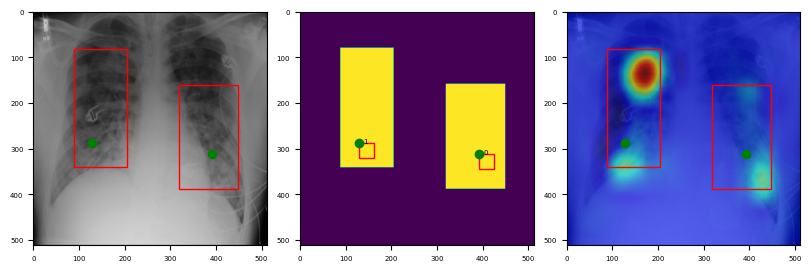

In [163]:
### Visualization
plot_test(all_df, df_disease, overall_prec, dic_disease_prec_acti['0'][0], img_path, anot_path, k=6, size=(8, 4))

In [47]:
'''
i = 0
ps = 33
fig = plt.figure(figsize=(4,2), layout='constrained')
mask = plt.imread(save_dir + '/' + aa)
x, y = coords[i][0], coords[i][1]
m = mask[y:y+ps, x:x+ps]
print(int(m.max()))
m2 = overlay[y:y+ps, x:x+ps, :]

ax = fig.add_subplot(1, 2, 1)
ax.imshow(m)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(m2)
'''
print()

## Posthoc analysis

In [ ]:
ffnames = list(activation.keys())

In [132]:
target_layer = model.layer4[-1]
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model), 
      'GradCam': LayerGradCam(model, target_layer)} #, 'Smooth_GradCam': smooth_grad_cam

In [134]:
ffnames = df_test.filename.tolist()
len(ffnames)

2230

In [135]:
d_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, s=60, target=1)

  0%|          | 0/2230 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 2230/2230 [15:05<00:00,  2.46it/s]


In [183]:
d_attrib_dic.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [136]:
h_attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, s=60, target=0)

100%|██████████| 2230/2230 [15:39<00:00,  2.37it/s]


In [191]:
res_pred = df_test[df_test.level==1]['res_pred'].tolist()
fname_disease = df_disease.filename.tolist()

dd_attrib_dic = {}
for key, act in d_attrib_dic.items():
    tmp_act = {ll: act[ll] for ll in fname_disease}
    dd_attrib_dic[key] = tmp_act

dd_attrib_dic.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [193]:
score_lists, score_tp_lists, df_outs = {}, {}, {}
xai_name = list(xai.keys()) # list of saliency methods

#if overlap:
#    score_lists['conv_resnet'] = topk_conv_scores
#    score_tp_lists['conv_resnet'] = topk_conv_scores_tp
#else:
#    score_lists['conv_resnet'] = topk_score2
#    score_tp_lists['conv_resnet'] = topk_scores_tp2

for name in xai_name: # 
    print(name)
    df_out, scores, scores_tp = get_topk_precision(dd_attrib_dic, res_pred, anot_path, thresh=0.003, k=30, xchest=True, posthoc=name)
    df_out_, scores_, scores_tp_ = get_topk_non_overlap_precision(dd_attrib_dic, res_pred, img_path, anot_path, thresh=0.003, k=30, xchest=True, posthoc=name)
        
    df_outs[name] = (df_out, df_out_)
    score_lists[name] = (scores, scores_)
    score_tp_lists[name] = (scores_tp, scores_tp_)

GuidedBackprop


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


IntegratedGradients


100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


GradCam


100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


In [194]:
score_lists.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [195]:
print(score_lists['GuidedBackprop'])

([0.651, 0.664, 0.665, 0.663, 0.663, 0.659, 0.66, 0.657, 0.651, 0.648, 0.646, 0.642, 0.636, 0.632, 0.628, 0.626, 0.62, 0.615, 0.612, 0.608, 0.604, 0.599, 0.595, 0.591, 0.587, 0.583, 0.579, 0.575, 0.571], [0.612, 0.62, 0.62, 0.624, 0.625, 0.624, 0.623, 0.62, 0.62, 0.617, 0.614, 0.609, 0.605, 0.602, 0.599, 0.598, 0.595, 0.59, 0.586, 0.583, 0.581, 0.576, 0.573, 0.569, 0.566, 0.562, 0.558, 0.555, 0.551])


In [196]:
print(score_tp_lists['GradCam'])

([0.726, 0.646, 0.578, 0.53, 0.493, 0.463, 0.442, 0.423, 0.409, 0.397, 0.382, 0.371, 0.361, 0.352, 0.345, 0.338, 0.332, 0.327, 0.322, 0.318, 0.315, 0.313, 0.312, 0.311, 0.31, 0.309, 0.309, 0.308, 0.308], [0.698, 0.697, 0.696, 0.693, 0.687, 0.684, 0.673, 0.666, 0.655, 0.645, 0.637, 0.628, 0.619, 0.611, 0.603, 0.595, 0.588, 0.582, 0.574, 0.567, 0.56, 0.553, 0.547, 0.541, 0.534, 0.529, 0.524, 0.519, 0.514])


In [203]:
res_attrib_precisions = {key: val[1] for key, val in score_lists.items()}
res_attrib_precisions.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [205]:
all_topk_tp_precision = cres_presisions | res_attrib_precisions
all_topk_tp_precision.keys()

dict_keys(['0', '8e4', '9e4', '1e3', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

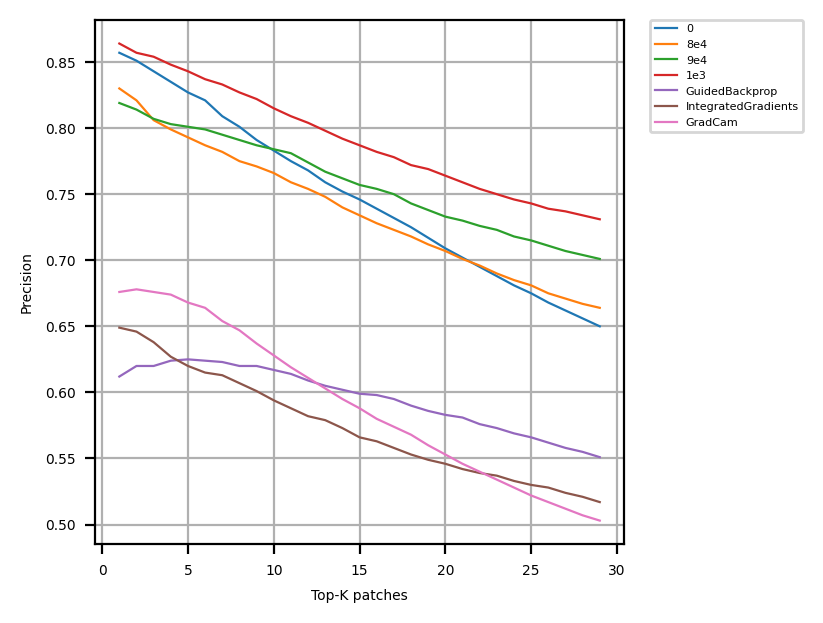

In [212]:
## plot precision
plot_precision(all_topk_tp_precision, bb=30, fs=7, lfs=4, out=True, size=(4,3)) #score_tp_lists, score_lists
#plt.savefig(f'./tmp/precision.{format}', format=format) 

## Activation precision
Quantify what proportion of positive activations compare to the ground truth annotations as marked by the radiologist.

In [55]:
dic_disease_prec_acti.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [15]:
# Good classifications => disease activations
df_disease_pred_good = df_disease_pred[df_disease_pred.level==1]

print(df_disease_pred.shape, df_disease_pred_good.shape)

fname_disease_pred = df_disease_pred_good.filename.tolist()

(797, 16) (779, 16)


In [122]:
# only keep activivation from good prediction
cres_good_pred_act_dic = {}

for key, (_, d_act, _, _, _) in dic_prec_acti.items():
    tmp_act = {ll: d_act[ll] for ll in fname_disease_pred}
    cres_good_pred_act_dic[key] = tmp_act

cres_good_pred_act_dic.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [123]:
res_good_pred_att_dic = {}

for key , d_act in d_attrib_dic.items():
    tmps_act = {ll: d_act[ll] for ll in fname_disease_pred}
    res_good_pred_att_dic[key] = tmps_act

In [124]:
all_good_pred_act_att = cres_good_pred_act_dic | res_good_pred_att_dic
all_good_pred_act_att.keys()

dict_keys(['0', '8e4', '9e4', '1e3', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [53]:
list_act_prec = {}

for name, act in tqdm(all_good_pred_act_att.items()):
    precis, _, _, _, _, _ = get_activation_precision(act, img_path, anot_path, scale=True, thresh=0)
    list_act_prec[name] = precis.mean()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:04<00:00, 17.75s/it]


In [54]:
list_act_prec

{'0': 0.1572009,
 '8e4': 0.09968767,
 '9e4': 0.10486675,
 '1e3': 0.12431463,
 'GuidedBackprop': 0.13591745,
 'IntegratedGradients': 0.13520449293966624,
 'GradCam': 0.13333595}

#### Test activation precision

In [57]:
# 'Conv_res', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'
actis = all_good_pred_act_att['0']

In [58]:
pp = '20f39b8e-be82-4f24-8791-651533a73184.png'
aaa = {pp: actis[pp]}

In [75]:
fnames = list(actis.keys())
pp = fnames[167]
aaa = {pp: actis[pp]}

In [110]:
act_prec, dic_score, dic_sign_acti, dic_acti, dic_mask, dic_img = get_activation_precision(aaa, img_path, anot_path, 
                                                                                scale=True, thresh=1.5, test=True, n=1)

['070c921f-171c-420c-915b-e49e3f600c38.png']


In [111]:
act_prec

array([0.8802])

In [112]:
file_keys = list(dic_img.keys())
file = random.choice(file_keys)

In [113]:
s_act, m_act, i_mask, i_img = dic_sign_acti[file], dic_acti[file], dic_mask[file], dic_img[file]
np.unique(i_mask), np.unique(s_act), i_mask.shape

(array([0., 1.], dtype=float32), array([False,  True]), (512, 512))

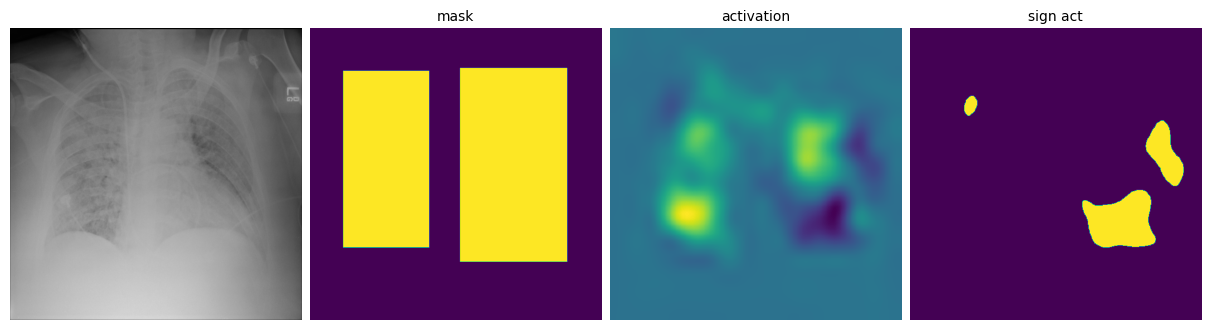

In [114]:
size = (12, 4)
imgs = [i_img, i_mask, m_act, s_act]
title = {0: " ", 1:'mask', 2:'activation', 3:'sign act'}

plot_img_heat_att(imgs, title, size, fs=10)

In [115]:
print(m_act.min(), m_act.max(), s_act.min(), s_act.max())

t = 1.5
print(np.sum(s_act > 0), np.sum(m_act > t))

num = i_mask * s_act
print(num.sum())

print(i_mask.sum(), s_act.sum())

act_pres = (i_mask * s_act).sum() / s_act.sum()
print(act_pres)

-43.570244 72.96944 False True
13989 105320
12313.0
110730.0 13989
0.8801915790978626


In [116]:
len(actis)

779

In [117]:
act_prec, dic_score, dic_sign_acti, dic_acti, dic_mask, dic_img = get_activation_precision(actis, img_path, anot_path, 
                                                                                           scale=True, thresh=1.5)

In [118]:
act_prec.mean()

0.18748061617458278

In [103]:
threshold = 0.6
indexes = np.where(act_prec > threshold)[0]
values = act_prec[indexes]

In [119]:
#indexes

In [120]:
#values

In [93]:
i=1
indexes[i], values[i]

(13, 0.4402)

### Pointing game metric

In [125]:
df_test.head(2)

filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   

   level  res_conf  res_pred  cres_conf  cres_pred  cres_8e4_pred  \
0      1       1.0         1      0.997          1              1   
1      1       1.0         1      0.999          1              1   

   cres_8e4_conf  cres_9e4_pred  cres_9e4_conf  cres_1e3_pred  cres_1e3_conf  
0          0.789              1          0.767              1          0.738  
1          0.827              1          0.790              1          0.821

In [127]:
df_disease_pred = df_test[(df_test.res_pred==1) & (df_test.cres_pred==1) & (df_test.cres_8e4_pred==1) & (df_test.cres_9e4_pred==1) & (df_test.cres_1e3_pred==1)]
df_healthy_pred = df_test[(df_test.res_pred==0) & (df_test.cres_pred==0) & (df_test.cres_8e4_pred==0) & (df_test.cres_9e4_pred==0) & (df_test.cres_1e3_pred==0)]

fnames_healthy = df_healthy_pred.filename.tolist()
fnames_disease = df_disease_pred.filename.tolist()

len(df_healthy_pred), len(df_disease_pred)

(1275, 797)

In [130]:
cres_heathy_disease_acts = {}

for key, (_, d_act, h_act, _, _) in dic_prec_acti.items():
    tmp_d_act = {ll: d_act[ll] for ll in fnames_disease}
    tmp_h_act = {ll: h_act[ll] for ll in fnames_healthy}
    cres_heathy_disease_acts[key] = (tmp_h_act, tmp_d_act)

cres_heathy_disease_acts.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

In [133]:
attrib_healthy_disease_acts = {} #(h_attrib_dic, d_attrib_dic)

for key in d_attrib_dic.keys():
    tmp_h_dic = {ll: h_attrib_dic[key][ll] for ll in fnames_healthy}
    tmp_d_dic = {ll: d_attrib_dic[key][ll] for ll in fnames_disease}
    attrib_healthy_disease_acts[key] = (tmp_h_dic, tmp_d_dic)

attrib_healthy_disease_acts.keys()

dict_keys(['GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [134]:
pg_activation_dic = cres_heathy_disease_acts | attrib_healthy_disease_acts
pg_activation_dic.keys()

dict_keys(['0', '8e4', '9e4', '1e3', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

In [136]:
len(pg_activation_dic['0'][0])

1275

In [152]:
# Move 'b' to the end
key_to_move = 'IntegratedGradients'
my_dict = {k: pg_activation_dic[k] for k in pg_activation_dic if k != key_to_move}
my_dict[key_to_move] = pg_activation_dic[key_to_move]

my_dict.keys()

dict_keys(['0', '8e4', '9e4', '1e3', 'GuidedBackprop', 'GradCam', 'IntegratedGradients'])

In [140]:
pg_acts = {}
for idx, (name, actt) in enumerate(pg_activation_dic.items()): 
    heathy_act, disease_act = actt
    pg_score = get_pointing_game_sensitivity_score(disease_act, heathy_act, bar=False)
    pg_acts[name] = pg_score
    
    if name =='GradCam':
        print(f'{name}\t\t\t| {pg_score}')
    elif name == 'GuidedBackprop':
        print(f'{name}\t\t| {pg_score}')
    elif name == 'IntegratedGradients':
        print(f'{name}\t| {pg_score}')
    else:
        print(f'{name}\t\t\t| {pg_score}')

0			| 0.34077898917373683
8e4			| 0.21369265308681412
9e4			| 0.21774641275070875
1e3			| 0.28848528516885397
GuidedBackprop		| 0.24882386289997843
IntegratedGradients	| 0.24967394487866224
GradCam			| 0.19497383256606624


## Sensitivity / Faithfulness

In [59]:
'''
to_save = {'cres_non_overlap_patch_scores': cres_non_overlap_patch_scores, # (non_overlap_patch_scores, acts)
          'no_rand_patch_scores': no_rand_patch_scores,
          'cres_df_prec_sens': cres_df_prec_sens,
           'cres_patch_scores': cres_patch_scores,
          'cres_rand_deletion': cres_rand_deletion,
          'cres_overlap_deletion': cres_overlap_deletion,
          'cres_rand_deletion': cres_rand_deletion, #(dic_rand_del, rand_perf)
           'cres_overlap_deletion': cres_overlap_deletion, # (dic_deletion, perform, dic_imgs)
          'cres_non_overlap_deletion': cres_non_overlap_deletion, # (dic_deletion2, perform2, dic_imgs2)
           'attrib_sensitivity': attrib_sensitivity }  

with open(f'{model_weights}ResNet50/rsna/files/sensitivity_file.pkl', 'wb') as file: 
    pickle.dump(to_save, file)
'''
print()

In [16]:
# df precision
print(df_disease_pred_good.shape)
precisions_fnames = df_disease_pred_good.filename.tolist()

#sort_df   = final_df.sort_values(by=['res_conf', 'cres_conf'], ascending=False).reset_index(drop=True)
#final_df.shape, final_df.res_conf.min(), final_df.res_conf.max(), final_df.cres_conf.min(), final_df.cres_conf.max()

(779, 16)


In [17]:
cres_non_overlap_patch_scores = {}

for key, (att, _) in dic_disease_prec_acti.items():
    acts = {fname: att[fname] for fname in precisions_fnames}
    non_overlap_patch_scores = get_non_overlap_patches_scores(acts, img_path, bar=True)
    cres_non_overlap_patch_scores[key] = (non_overlap_patch_scores, acts)

100%|██████████| 779/779 [00:17<00:00, 43.39it/s]


In [18]:
random_activations = get_random_activation(precisions_fnames)
no_rand_patch_scores = get_non_overlap_patches_scores(random_activations, img_path, bar=True)

100%|██████████| 779/779 [00:18<00:00, 42.75it/s]


In [20]:
cres_df_prec_sens = {}
for key, (_, act) in cres_non_overlap_patch_scores.items():
    df_prec_sens = get_precision_sensitivity(act, thresh=0)
    cres_df_prec_sens[key] = df_prec_sens

779it [04:07,  3.14it/s]
779it [02:08,  6.06it/s]
779it [02:12,  5.89it/s]
779it [02:54,  4.45it/s]


In [21]:
# get overlap
cres_patch_scores = {}
for key, df_prec_sens_ in  cres_df_prec_sens.items():
    patch_scores = get_overlap_patches_scores(df_prec_sens_)
    cres_patch_scores[key] = patch_scores

100%|██████████| 39210/39210 [02:41<00:00, 242.70it/s]


In [26]:
#non_overlap_rand_patch_scores
cres_rand_deletion = {}

for key, cmodel in dic_models.items():
    dic_rand_del, rand_perf, dic_rand_imgs = get_deletion_analysis(cfg, cmodel, no_rand_patch_scores, img_path, k=30, act=True)
    cres_rand_deletion[key] = (dic_rand_del, rand_perf)

100%|██████████| 29/29 [16:38<00:00, 34.42s/it]


In [28]:
#patch_scores
cres_overlap_deletion = {}
for key, cmodel in dic_models.items(): #* to run again -> cmodel vs conv_model
    dic_deletion, perform, dic_imgs = get_deletion_analysis(cfg, cmodel, cres_patch_scores[key], img_path, k=30, act=True)
    cres_overlap_deletion[key] = (dic_deletion, perform, dic_imgs)

100%|██████████| 29/29 [16:45<00:00, 34.67s/it]


In [29]:
#non_overlap_patch_scores
cres_non_overlap_deletion = {}
for key, cmodel in dic_models.items():
    dic_deletion2, perform2, dic_imgs2 = get_deletion_analysis(cfg, cmodel, cres_non_overlap_patch_scores[key][0], img_path, k=30, act=True)
    cres_non_overlap_deletion[key] = (dic_deletion2, perform2, dic_imgs2)

100%|██████████| 29/29 [16:48<00:00, 34.79s/it]


In [35]:
print(len(rand_perf), rand_perf)
print(len(perform), perform)
print(len(perform2), perform2)

30 [1, 1.0, 0.9974, 0.9961, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974, 0.9961, 0.9974, 0.9974, 0.9974, 0.9974, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9974, 0.9974, 0.9974]
30 [1, 0.9782, 0.9795, 0.9872, 0.9884, 0.991, 0.9961, 0.9961, 0.9987, 0.9974, 0.9974, 0.9974, 0.9987, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
30 [1, 0.9859, 0.9795, 0.9705, 0.9666, 0.9576, 0.9538, 0.9487, 0.9499, 0.9409, 0.9371, 0.9307, 0.9217, 0.9166, 0.9166, 0.9114, 0.9114, 0.9063, 0.8999, 0.9063, 0.9037, 0.9063, 0.8999, 0.8999, 0.8986, 0.8999, 0.905, 0.9076, 0.9127, 0.9076]


In [51]:
tmp_fname = random.sample(precisions_fnames, 3)
print(tmp_fname)

['8baa988a-3db3-4abb-8824-5532a4a020da.png', 'c9a95d7f-8a6f-49c5-88d3-8a1cfaaf51a4.png', 'a2ddccd7-9c2b-4d81-9375-928b418da482.png']


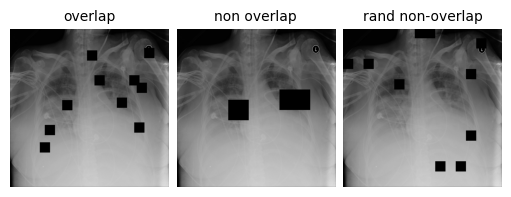

In [52]:
i, j=1, 10
list_imgs = [dic_imgs[j][tmp_fname[i]], dic_imgs2[j][tmp_fname[i]], dic_rand_imgs[j][tmp_fname[i]]]
dic_title = {0: "overlap", 1:'non overlap', 2:'rand non-overlap'}

plot_img_heat_att(list_imgs, dic_title, size=(5,10), fs=10)

In [53]:
cres_non_overlap_sensitivity = {key: val[1] for key, val in cres_non_overlap_deletion.items()}
cres_non_overlap_sensitivity.keys()

dict_keys(['0', '8e4', '9e4', '1e3'])

Area under the deletion curve
0: 	 0.9287758620689655
8e4: 	 0.9701844827586206
9e4: 	 0.9259965517241379
1e3: 	 0.9275448275862068


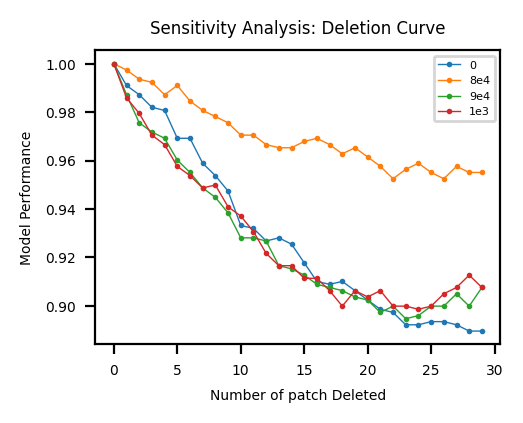

In [42]:
plot_deletion_curve(cres_non_overlap_sensitivity, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

In [31]:
res_attrib_sens = {}

for key, actt in d_attrib_dic.items():
    tmp_act = {key2: actt[key2] for key2 in precisions_fnames}
    res_attrib_sens[key] = tmp_act

In [ ]:
attrib_sensitivity = {}

for name, actis in tqdm(res_attrib_sens.items()):
    no_over_patch_scores = get_non_overlap_patches_scores(actis, img_path, bar=False)
    dic_del, perf2, dic_img = get_deletion_analysis(cfg, model, no_over_patch_scores, img_path, bar=False, k=30, act=False)
    attrib_sensitivity[name] = perf2

  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
all_sensitivity = cres_non_overlap_sensitivity | attrib_sensitivity
all_sensitivity.keys()

dict_keys(['0', '8e4', '9e4', '1e3', 'GuidedBackprop', 'IntegratedGradients', 'GradCam'])

Area under the deletion curve. 0: 0.9287758620689655
Area under the deletion curve. 8e4: 0.9701844827586206
Area under the deletion curve. 9e4: 0.9259965517241379
Area under the deletion curve. 1e3: 0.9275448275862068
Area under the deletion curve. GuidedBackprop: 0.9806344827586206
Area under the deletion curve. IntegratedGradients: 0.9832689655172413
Area under the deletion curve. GradCam: 0.9853862068965518


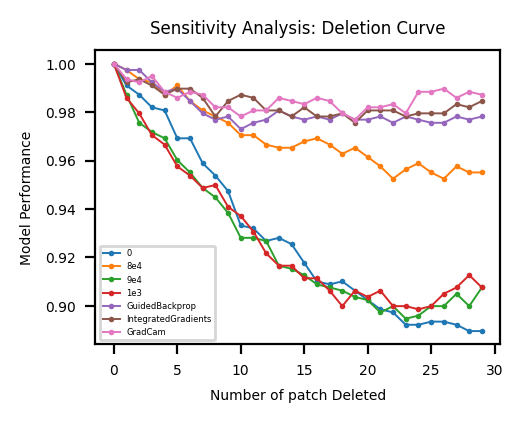

In [55]:
plot_deletion_curve_v2(all_sensitivity, label='Deletion Curve', bb=30, ls=0.7, frac=False, fs=7, ms=1, lfs=3, size=(2.5,2))

#### Posthoc visualization

In [173]:
pred, activation = get_prediction(model, ts_img, act=False)

Logit distribution: 	  [0.043 0.957]
Probabilities: 		 0.9573, 	 Class: 1


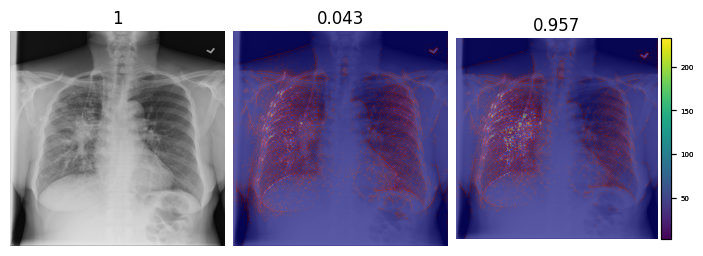

In [175]:
explainer = GuidedBackprop(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer, v2=False, s=512, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, pred[0], (6.69,2.5), nrow=1, fs=12)

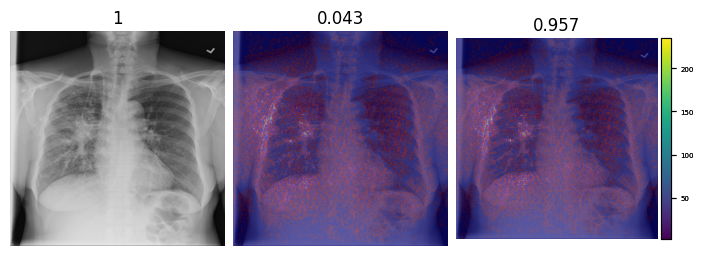

In [176]:
explainer2 = IntegratedGradients(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer2, v2=False, s=512, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, pred[0], (6.69,2.5), nrow=1, fs=12)

## Model selection

In [92]:
#to_save = {'overal': preci, 'topk': topk_preci, 'params': sort_test_reg, 'sort_regs_precs': sorted_regs_preci, 'regs_precs': regs_preci}

#with open(f'{model_weights}ResNet50/rsna/files/sparse_model_selection.pkl', 'wb') as file: 
#    pickle.dump(to_save, file)

with open(f'{model_weights}ResNet50/rsna/files/sparse_model_selection.pkl', 'rb') as file:  
    save_model_selection = pickle.load(file)

In [93]:
preci = save_model_selection['overal']
regs_precis = save_model_selection['regs_precs']
sort_test_reg = save_model_selection['params']
topk_precision = save_model_selection['topk']

In [94]:
data = test[test.level==1].reset_index(drop=True)
print(test.shape, data.shape)
test.head(2)

(2230, 6) (902, 6)


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   

   level  
0      1  
1      1

In [95]:
data_fname = os.listdir(anot_path)
len(data_fname)

902

In [64]:
test_reg = [(0.953, 0.987, 0, '0'),  (0.952, 0.986, 1e-4, '1e4'), (0.955, 0.984, 2e-4, '2e4'), (0.954, 0.984, 3e-4, '3e4'), 
      (0.952, 0.985, 4e-4, '4e4'), (0.951, 0.987, 5e-4, '5e4'), (0.953, 0.987, 6e-4, '6e4'), (0.948, 0.984, 7e-4, '7e4'), 
      (0.945, 0.982, 8e-4, '8e4'), (0.938, 0.980, 9e-4, '9e4'), (0.960, 0.986, 2e-05, '2e5'), (0.952, 0.987, 4e-05, '4e5'), 
      (0.954, 0.986, 5e-05, '5e5'), (0.954, 0.988, 6e-05, '6e5'), (0.954, 0.988, 8e-05, '8e5'), 
      (0.941, 0.979, 1e-3, '1e3'), (0.738, 0.799, 2e-3, '2e3')]

regs = [ll[2] for ll in test_reg]
sort_test_reg = sorted(test_reg, key=lambda x: x[2])

In [96]:
regs_preci = list(zip(regs, preci))
print(regs_preci)

[(0, 0.189), (0.0001, 0.581), (0.0002, 0.632), (0.0003, 0.642), (0.0004, 0.649), (0.0005, 0.653), (0.0006, 0.714), (0.0007, 0.699), (0.0008, 0.742), (0.0009, 0.751), (2e-05, 0.342), (4e-05, 0.416), (5e-05, 0.45), (6e-05, 0.481), (8e-05, 0.458), (0.001, 0.788), (0.002, nan)]


In [97]:
sorted_regs_preci = sorted(regs_preci)
print(sorted_regs_preci)

[(0, 0.189), (2e-05, 0.342), (4e-05, 0.416), (5e-05, 0.45), (6e-05, 0.481), (8e-05, 0.458), (0.0001, 0.581), (0.0002, 0.632), (0.0003, 0.642), (0.0004, 0.649), (0.0005, 0.653), (0.0006, 0.714), (0.0007, 0.699), (0.0008, 0.742), (0.0009, 0.751), (0.001, 0.788), (0.002, nan)]


In [ ]:
model_surfix = [ll[3] for ll in test_reg]
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/rsna/reg'
preci, topk_preci = run_eval(cfg, data, model_surfix, prefix, model_path, img_path, anot_path, thresh=1, k=30, xchest=True)

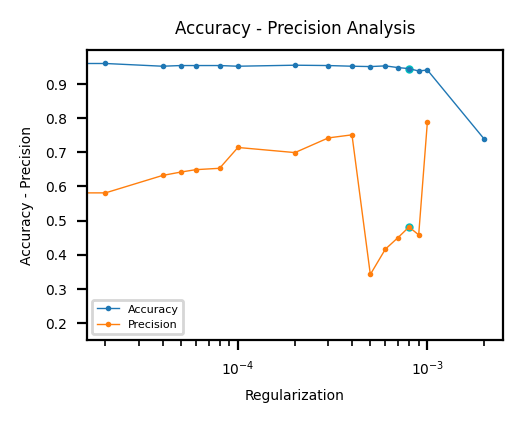

In [99]:
#r_precs = [ll[1] for ll in sorted_regs_preci]
#plot_overall_accuracy(sort_test_reg, r_precs, log_ax=True, i=0, j=2, k=13, fs=7, lfs=4, size=(2.5,2))

r_precs = [ll[1] for ll in regs_precis]
plot_overall_accuracy(sort_test_reg, r_precs, log_ax=True, i=0, j=2, k=13, fs=7, lfs=4, size=(2.5,2))

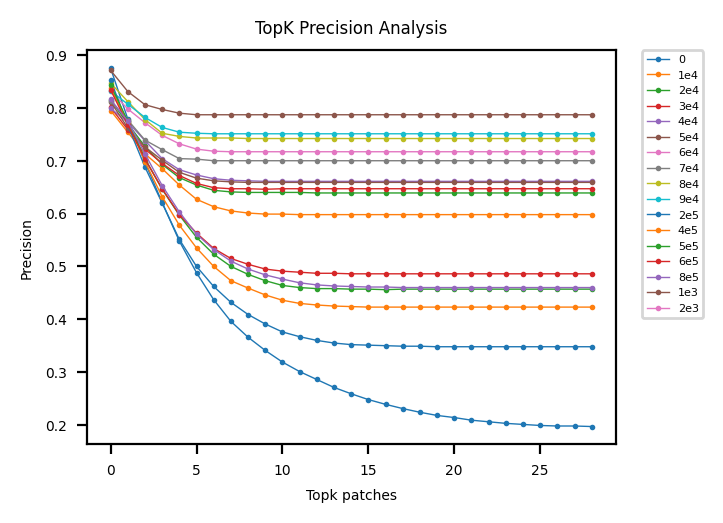

In [100]:
plot_topk_reg(topk_precision, 'TopK Precision Analysis', i=1, fs=7, lfs=4, size=(3.5,2.5))

In [89]:
topk_preci

['topk']